*Berrendero, J.R., Coín, A. and Cuevas, A. ["A Bayesian approach to functional regression: theory and computation"](https://arxiv.org/abs/2312.14086)*

# Bayesian RKHS-based Functional Logistic Regression with RJMCMC

## Imports and configuration

In [1]:
from itertools import product
from multiprocessing import Pool

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from eryn.ensemble import EnsembleSampler
from eryn.moves import CombineMove, StretchMove
from eryn.state import State
from rkbfr_jump import chain_utils, plot_utils, prediction, run_utils
from rkbfr_jump import simulation_utils as simulation
from rkbfr_jump import utility
from rkbfr_jump.likelihood import RKHSLikelihoodLogistic
from rkbfr_jump.moves import GroupMoveRKHS, MTRJMoveRKHS, RJMoveRKHS
from rkbfr_jump.parameters import ThetaSpace
from rkbfr_jump.prior import RKHSPriorLogistic
from rkbfr_jump.update import AdjustStretchScaleCombineMove
from scipy.stats import mode as mode_discrete
from scipy.stats import trim_mean
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline

# Random seed for reproducibility
SEED = 2024
RNG = np.random.default_rng(SEED)
np.random.seed(SEED)

# Floating point precision for display
np.set_printoptions(precision=4, suppress=True)
pd.set_option("display.precision", 4)
pd.set_option("styler.format.precision", 4)

# Extensions
%load_ext autoreload
%load_ext watermark
%autoreload 2

In [19]:
# Plots config

SAVE_FIG = False
SAVE_FIG_LATEX_PREAMBLE = "Preprint"
DIR_SAVE = "figures/"
FONT_SIZE_LATEX = 15
COLORS = ["darkgreen", "blue", "orange", "purple", "red"]

if SAVE_FIG:  # Mirror the style of a specific LaTeX document
    if SAVE_FIG_LATEX_PREAMBLE == "Preprint":
        plt.rcParams.update(
            {
                "font.family": "serif",
                "font.size": FONT_SIZE_LATEX,
                "axes.linewidth": 0.75,
                "text.usetex": True,
                "pgf.rcfonts": False,
                "pgf.texsystem": "pdflatex",  # default is xetex
                "pgf.preamble": "\n".join(
                    [
                        r"\renewcommand{\rmdefault}{ptm}",
                        r"\renewcommand{\sfdefault}{phv}",
                        r"\usepackage[T1]{fontenc}",
                        r"\usepackage[english]{babel}",
                        r"\usepackage{microtype}",
                        r"\makeatletter\g@addto@macro\bfseries{\boldmath}\makeatother",  # bold math
                    ]
                ),
            }
        )
    elif SAVE_FIG_LATEX_PREAMBLE == "BA":
        plt.rcParams.update(
            {
                "font.family": "serif",
                "font.size": FONT_SIZE_LATEX,
                "axes.linewidth": 0.5,
                "text.usetex": True,
                "pgf.rcfonts": False,
                "pgf.texsystem": "lualatex",  # default is xetex
                "pgf.preamble": "\n".join(
                    [
                        r"\usepackage{polyglossia}",
                        r"\usepackage[T1]{fontenc}",
                        r"\usepackage{microtype}",
                        r"\usepackage{newcomputermodern}",
                        r"\DeclareFontFamily{OMX}{lmex}{}",
                        r"\DeclareFontShape{OMX}{lmex}{m}{n}{ <-> lmex10}{}",
                    ]
                ),
            }
        )
    else:
        raise ValueError("Incorrect Latex preamble.")
else:
    plt.rcParams.update(plt.rcParamsDefault)
    %matplotlib inline
    plt.rcParams["figure.figsize"] = [6, 4]
    %config InlineBackend.figure_format = 'retina'
    plt.style.use("arviz-darkgrid")

## Dataset

In [2]:
# -- Dataset configuration

# Data generation process
SYNTHETIC_DATA = True
MODEL_GEN = "RKHS"  # 'L2', 'RKHS' or 'MIXTURE'
REAL_DATA = "Medflies"  # 'Medflies', 'Phoneme' or 'Growth'
INITIAL_SMOOTHING = False

# Dataset parameters for simulations
n_grid = 100
n_samples = 300
train_frac = 2 / 3
tau_range = (0, 1)
label_noise = 0.05

# Regressor parameters
mean_vector = np.zeros(n_grid)
mean_vector2 = np.linspace(tau_range[0], tau_range[1], n_grid)
kernel_fn = simulation.brownian_kernel
kernel_fn2 = simulation.ornstein_uhlenbeck_kernel
smoothing_params = np.logspace(-2, 2, 50)

# Response parameters
beta_coef_true = (
    simulation.cholaquidis_scenario3
)  # True coefficient function for L2 model
beta_true = [-5.0, 5.0, 10.0]  # True components for RKHS model
tau_true = [0.1, 0.6, 0.8]  # True time instants for RKHS model
alpha0_true = -0.5  # the function get_data_logistic uses it inside as a default value

In [3]:
# -- Actual dataset generation

x_fd, y, grid = simulation.get_data_logistic(
    SYNTHETIC_DATA,
    MODEL_GEN if SYNTHETIC_DATA else REAL_DATA,
    n_samples=n_samples,
    n_grid=n_grid,
    mean_vector=mean_vector,
    kernel_fn=kernel_fn,
    beta_coef_true=beta_coef_true,
    beta_tau_true=[beta_true, tau_true],
    noise=label_noise,
    tau_range=tau_range,
    mean_vector2=mean_vector2,
    kernel_fn2=kernel_fn2,
    rng=RNG,
)

if not SYNTHETIC_DATA:  # Update dataset parameters
    n_grid = len(grid)
    n_samples = len(x_fd)

# Train/test split
idx_samples = np.arange(n_samples)
X_fd, X_test_fd, Y, Y_test, idx_train, idx_test = train_test_split(
    x_fd, y, idx_samples, stratify=y, train_size=train_frac, random_state=SEED
)

if INITIAL_SMOOTHING:
    # Nadaraya-Watson kernel smoothing
    X_fd, X_test_fd = simulation.smooth_data(X_fd, X_test_fd, smoothing_params)

# We always assume that the regressors are centered
X_m = X_fd.mean(axis=0)
X_fd = X_fd - X_m
X_test_fd = X_test_fd - X_m

# Get data matrices
X = X_fd.data_matrix.reshape(-1, n_grid)
X_test = X_test_fd.data_matrix.reshape(-1, n_grid)

# Scale training data for our methods so that SD=1
X_std_orig = np.std(X, axis=0)
X_scaled = 0.5 * X / X_std_orig

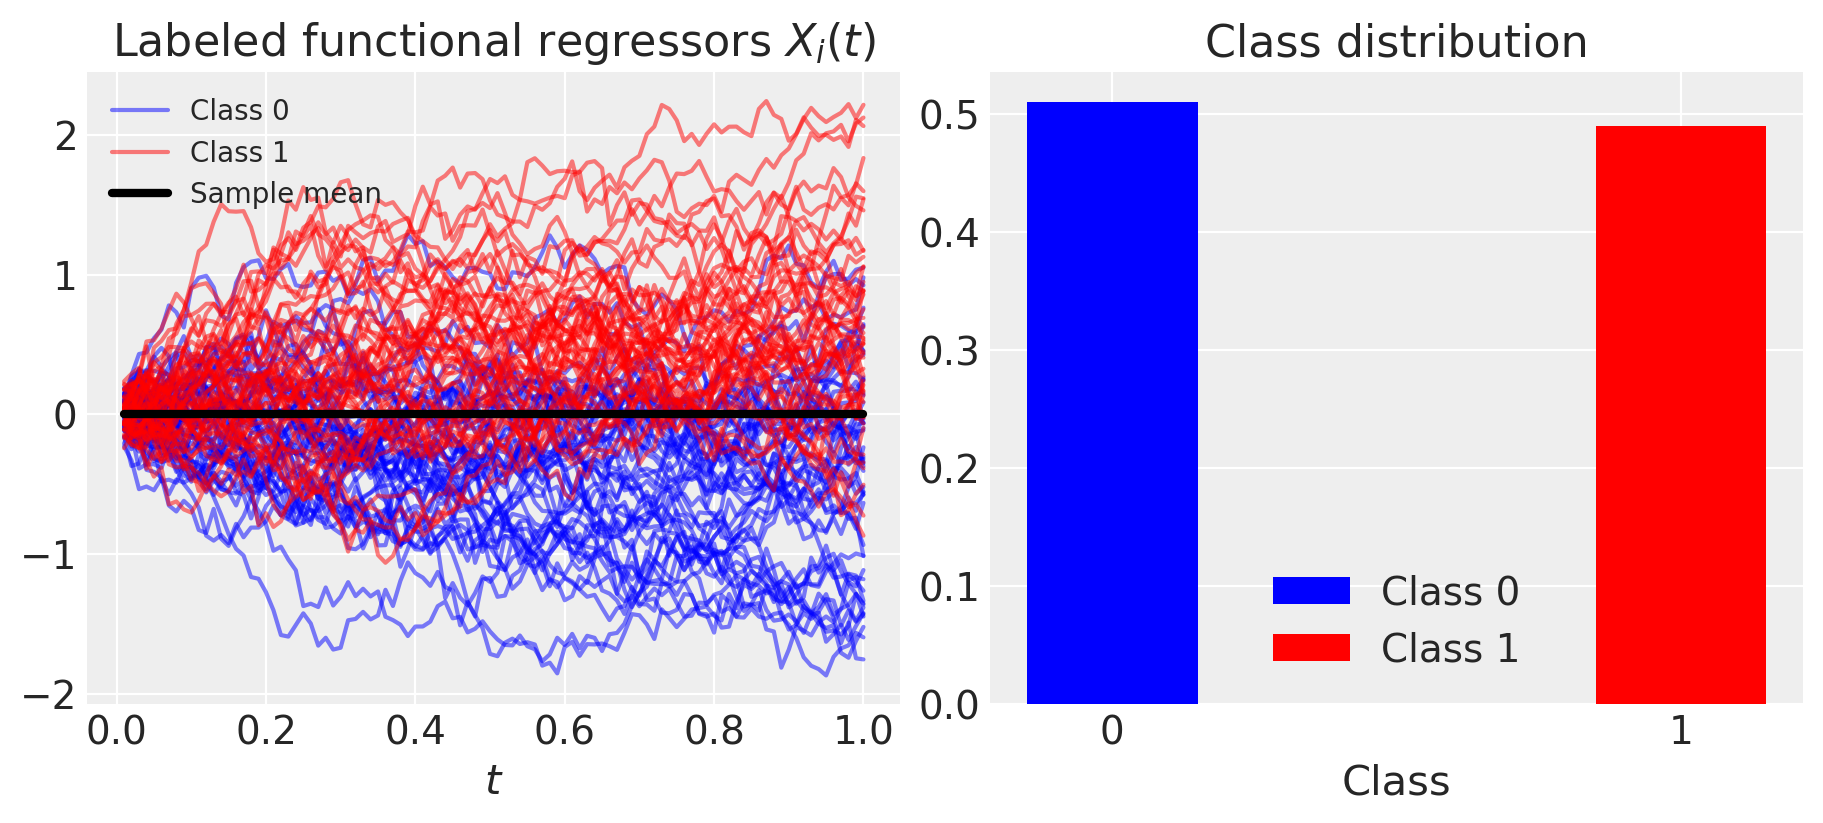

In [4]:
# -- Dataset visualization

plot_utils.plot_dataset_classification(
    X,
    Y,
    grid,
    n_samples=n_samples // 3,
)

if SAVE_FIG:
    plt.savefig(
        DIR_SAVE + "clf_analysis_dataset.pdf", bbox_inches="tight", backend="pgf"
    )

## Bayesian model

In [5]:
# -- Bayesian model parameters

TRANSFORM_SIGMA = True
RELABEL_STRATEGY = "auto"  # beta, tau or auto
THETA_SPACE = ThetaSpace(
    grid,
    names=["b", "t", "alpha0"],
    idx=[0, 1, 0],
)
DF_PRIOR_BETA = 5
SCALE_PRIOR_BETA = 2.5
SCALE_PRIOR_ALPHA0 = 10
MIN_DIST_TAU = 1
LAMBDA_P = 3  # None means uniform prior

### Prior

In [6]:
# -- Prior distributions

priors_simple = {
    "all_models_together": RKHSPriorLogistic(
        THETA_SPACE,
        df_beta=DF_PRIOR_BETA,
        scale_beta=SCALE_PRIOR_BETA,  # vague prior on beta; regressors are scaled to have SD=0.5
        scale_alpha0=SCALE_PRIOR_ALPHA0,
        lambda_p=LAMBDA_P,  # Only useful for the RJ move (not MT RJ)
        min_dist_tau=MIN_DIST_TAU,  # impose |t_i - t_j| > minimum_distance_tau
    )
}

### Likelihood

In [7]:
# -- Log-likelihood

ll = RKHSLikelihoodLogistic(
    THETA_SPACE,
    X_scaled,
    Y,
)

## Sampler

### Initial values

In [8]:
# -- Set reasonable initial values for all chains

branch_names = ["components", "common"]
nleaves_max = {"components": 5, "common": 1}
nleaves_min = {"components": 1, "common": 1}
ndims = {"components": 2, "common": 1}
nwalkers = 32
ntemps = 5

nsteps = 500
thin_by = 1
burn = 1500

# number of cores
njobs = 4
vectorize = True

coords, inds = chain_utils.setup_initial_coords_and_inds(
    ntemps,
    nwalkers,
    nleaves_max,
    ndims,
    THETA_SPACE,
    priors_simple["all_models_together"],
    Y,
    seed=SEED,
    kind="logistic",
)

## Experiments

In [9]:
# -- Set up moves
# IMPORTANT: moves, update and Likelihood objects must be re-created before sampling again

NUM_TRY = 2

# In-model move for alpha0
move_stretch = StretchMove(gibbs_sampling_setup="common", a=2)

# Sample all parameters leaf by leaf in the components branch (currently unused)
gibbs_sampling_setup_group = [
    (
        "components",
        np.zeros((nleaves_max["components"], ndims["components"]), dtype=bool),
    )
    for _ in range(nleaves_max["components"])
]
for i in range(nleaves_max["components"]):
    gibbs_sampling_setup_group[i][-1][i] = True

# In-model move for b and t
move_group = GroupMoveRKHS(
    THETA_SPACE,
    dist_measure="beta",
    nfriends=nwalkers,
    n_iter_update=100,
    gibbs_sampling_setup="components",  # gibbs_sampling_setup_group,
    a=2,
)

# MT RJ move: generate from prior
rjmoveMTRKHS = MTRJMoveRKHS(
    priors_simple["all_models_together"],
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    rj=True,
    gibbs_sampling_setup="components",  # Do not specify this if using dependent prior on beta
    num_try=NUM_TRY,
)

# RJ move: generate from prior
rjmoveRKHS = RJMoveRKHS(
    priors_simple["all_models_together"],
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    rj=True,
    gibbs_sampling_setup="components",  # Do not specify this if using dependent prior on beta
)

# update function for the parameter 'a' in the in-model moves
update_fn_group = AdjustStretchScaleCombineMove(
    idx_moves=[0, 1],
    target_acceptance=0.3,
    max_factor=0.1,
    supression_factor=0.1,
    min_a=1.1,
)
update_iters = 50

# -- Posterior sampling with Eryn (RJMCMC)

# re-set random seed for reproducible sampling
np.random.seed(SEED)

# sample
with Pool(njobs) as pool:
    ensemble = EnsembleSampler(
        nwalkers,
        ndims,
        ll.evaluate_vectorized if vectorize else ll.evaluate_sequential,
        priors_simple,
        pool=pool if not vectorize else None,
        vectorize=vectorize,
        provide_groups=vectorize,
        tempering_kwargs=dict(ntemps=ntemps),
        nbranches=len(branch_names),
        branch_names=branch_names,
        nleaves_max=nleaves_max,
        nleaves_min=nleaves_min,
        moves=CombineMove([move_group, move_stretch]),
        rj_moves=rjmoveMTRKHS if LAMBDA_P is None and NUM_TRY > 1 else rjmoveRKHS,
        update_fn=update_fn_group,
        update_iterations=update_iters,
    )

    # setup starting state
    state = State(coords, inds=inds)

    # run the sampler
    print(f"Sampling posterior distribution...")
    last_sample = ensemble.run_mcmc(
        state, nsteps, burn=burn, progress=True, thin_by=thin_by
    )

Sampling posterior distribution...


100%|██████████| 500/500 [00:04<00:00, 111.99it/s]


In [10]:
# -- Post-process the cold chain only

# 1. Get full chain, with shape (nsteps, nwalkers, nleaves_max, ndim) and corresponding indices
(
    full_chain_components,
    full_chain_common,
    inds_components_post,
    inds_common_post,
    idx_order,
) = chain_utils.get_full_chain_at_T(
    ensemble,
    THETA_SPACE,
    X_std_orig,
    T=0,
    relabel_strategy=RELABEL_STRATEGY,
    kind="logistic",
)

# 2. Get values of leaves (number of components) accross the chain
nleaves_all_T = ensemble.get_nleaves()["components"]
nleaves = nleaves_all_T[:, 0, ...]  # T=0

# Print sampling information
chain_utils.print_sampling_information(
    full_chain_components,
    full_chain_common,
    inds_components_post,
    THETA_SPACE,
    ensemble,
    idx_order,
    thin_by,
    num_try=NUM_TRY,
    display_notebook=True,
    kind="logistic",
)

* Last sample (T=0, W=0):


$b$     $t$
0  0.1281  0.8880
1  1.1044  0.8302
2  1.6949  0.4746
3     NaN     NaN
4     NaN     NaN


* Acceptance % (T=0)
[GroupMoveRKHS] [25.5  23.55 22.75 24.85 23.1  22.65 24.8  24.9  22.95 25.35 24.95 23.75
 24.85 24.3  25.95 25.45 24.35 24.8  24.5  25.3  24.15 24.15 24.1  23.3
 24.55 24.05 24.05 23.95 25.3  24.4  22.95 24.35]
[StretchMove] [76.1  78.05 79.8  78.55 78.   76.9  78.55 78.35 77.7  76.8  78.05 78.4
 78.35 77.8  77.95 78.05 77.85 77.55 76.35 78.9  79.2  77.7  77.45 79.25
 76.65 80.45 78.05 77.95 77.6  76.45 78.2  78.05]
[RJMoveRKHS] [20.6 20.2 21.  21.  19.4 18.6 21.  20.8 21.6 19.2 19.6 22.8 18.6 23.2
 20.  18.2 21.6 21.4 20.4 18.  22.  22.4 22.4 22.2 25.  25.4 23.6 22.
 21.8 19.2 23.  20.4]

* Temperature swaps accepted %: [40.9813 40.6687 39.9    40.4875]

* Last values of a (parameter of the in-model moves):
[GroupMoveRKHS] a=1.41
[StretchMove] a=4.72

* Chain ordered by: beta

* Gelman-Rubin diagnostic (should be near 1) 
  <R̂>: Mean value for all parameters

  --------------
 Model: components
   T 	 <R̂>
  --------------
   0	1.00
   1	1.00
   2	1.00
   3	1.00

### Save & load chain

In [50]:
SAVE_CHAIN = False
if SAVE_CHAIN:
    if SYNTHETIC_DATA:
        filename = (
            f"{kernel_fn.__name__ if REGRESSOR_GEN == 'GP' else 'GBM'}+{MODEL_GEN}"
        )
    else:
        filename = f"{REAL_DATA}"

    sampling_info = {
        "burn": burn,
        "thin_by": thin_by,
        "num_try": num_try if USE_MT_RJ else 1,
        "USE_MT_RJ": USE_MT_RJ,
        "TRANSFORM_SIGMA": TRANSFORM_SIGMA,
        "SD_PRIOR_BETA": SD_PRIOR_BETA,
        "RELABEL_STRATEGY": RELABEL_STRATEGY,
        "MIN_DIST_TAU": MIN_DIST_TAU,
        "LAMBDA_P": LAMBDA_P,
    }
    sampling_info_structured = np.array(
        list(sampling_info.items()), dtype=[("key", "U100"), ("value", "O")]
    )

    np.savez_compressed(
        f"results/chains/{filename}_{SEED}.npz",
        full_chain_components=full_chain_components,
        full_chain_common=full_chain_common,
        nleaves_all_T=nleaves_all_T,
        sampling_info=sampling_info_structured,
    )

In [51]:
LOAD_CHAIN = False
FILENAME_LOAD = "results/chains/brownian_kernel+RKHS_2024.npz"

if LOAD_CHAIN:
    loaded_chain = np.load(FILENAME_LOAD, allow_pickle=True)
    full_chain_components = loaded_chain["full_chain_components"]
    full_chain_common = loaded_chain["full_chain_common"]
    nleaves_all_T = loaded_chain["nleaves_all_T"]
    nleaves = nleaves_all_T[:, 0, ...]  # T=0
    sampling_info = dict(loaded_chain["sampling_info"])

    nsteps, nwalkers = full_chain_components.shape[:2]
    ntemps = nleaves_all_T.shape[1]
    nleaves_max = {"components": full_chain_components.shape[2], "common": 1}
    ndims = {
        "components": full_chain_components.shape[-1],
        "common": full_chain_common.shape[-1],
    }

    # Recover the variables stored in the sampling_info dict.
    # WARNING: This is unsafe and should be used only for testing purposes,
    # since it allows arbitrary code execution
    for key, value in sampling_info.items():
        exec(f"{key} = value")

    THETA_SPACE = ThetaSpace(
        grid,
        names=["b", "t", "alpha0", "sigma2"],
        idx=[0, 1, 0, 1],
        transform_sigma=TRANSFORM_SIGMA,
    )

## Analysis

### Flat posterior distributions (for all p)

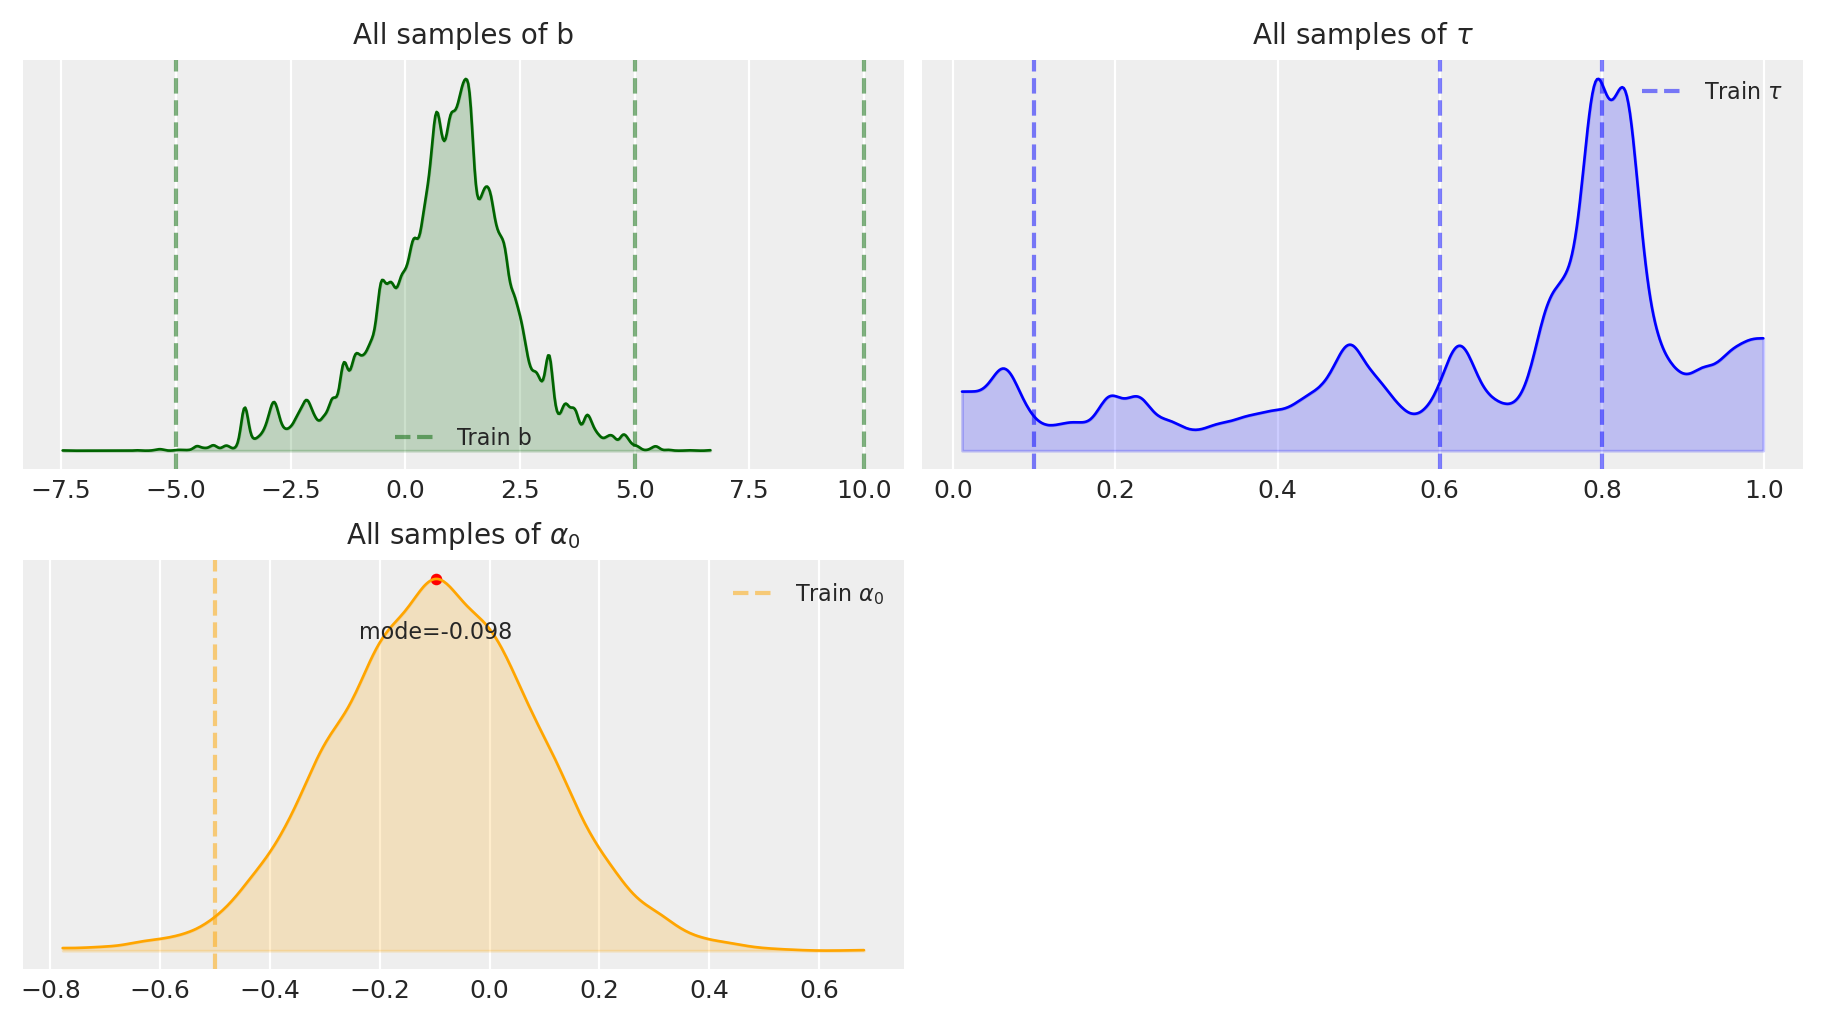

In [11]:
# Get flat chain, with shape (N, ndim), where N is the number of valid samples across all steps, walkers and leaves
flat_chain_components = chain_utils.get_flat_chain_components(
    full_chain_components, THETA_SPACE, ndims["components"]
)
flat_chain_common = full_chain_common.reshape(-1, 2)

samples_vars = [
    flat_chain_components[:, THETA_SPACE.idx_beta],
    flat_chain_components[:, THETA_SPACE.idx_tau],
    flat_chain_common[:, THETA_SPACE.idx_alpha0],
]
if SYNTHETIC_DATA and MODEL_GEN == "RKHS":
    ref_values = [beta_true, tau_true, alpha0_true]
else:
    ref_values = None

plot_utils.plot_flat_posterior(
    samples_vars, THETA_SPACE, COLORS, ref_values, plot_sigma2=False
)

if SAVE_FIG:
    plt.savefig(
        DIR_SAVE + "clf_analysis_flat_posterior.pdf", bbox_inches="tight", backend="pgf"
    )

### Trace plot for individual components (for all p)

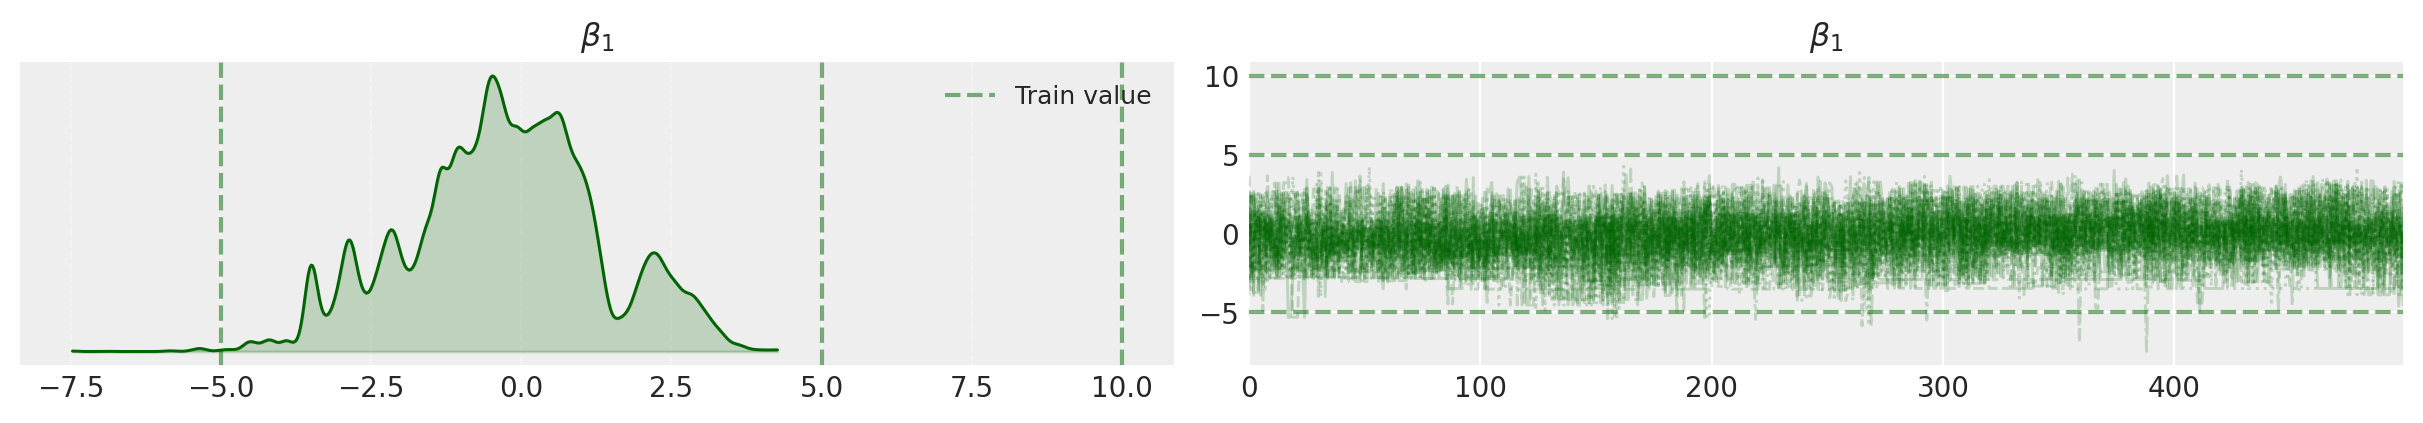

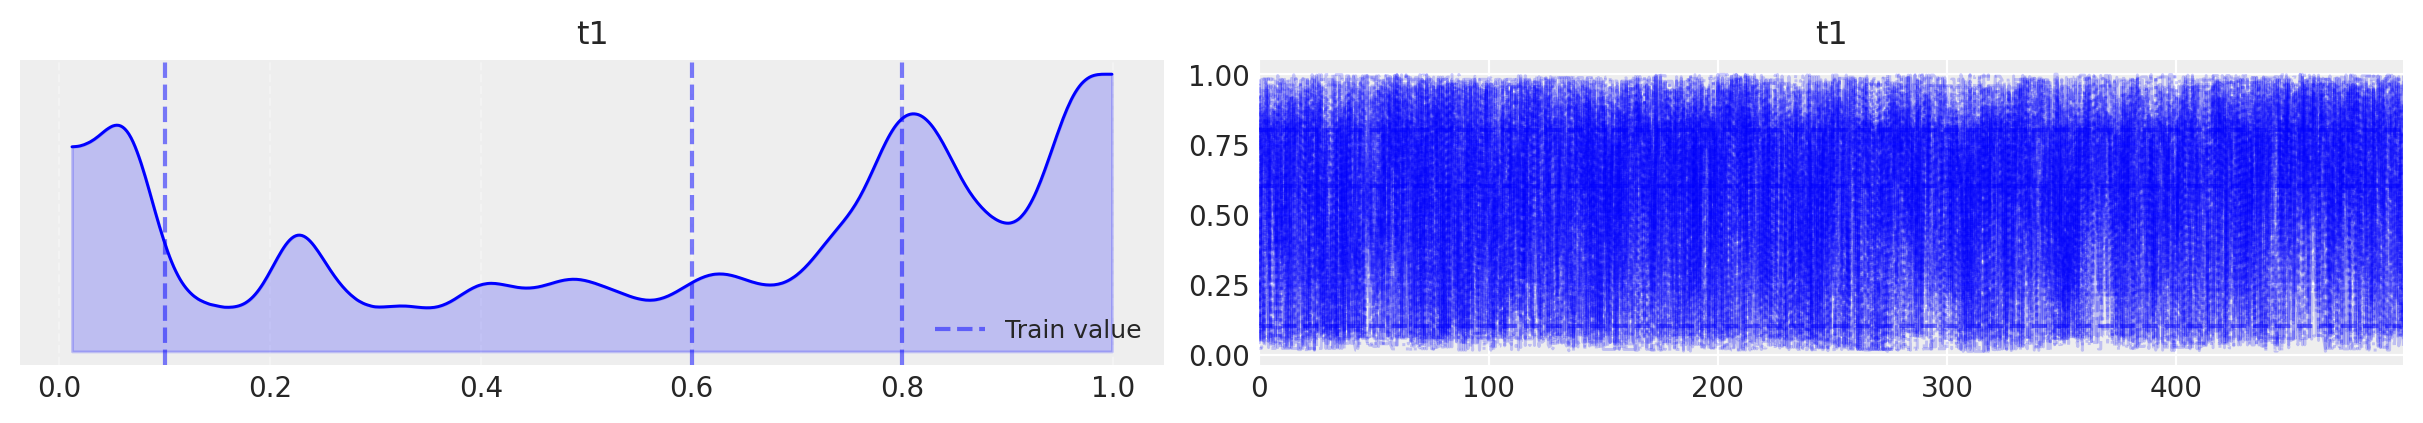

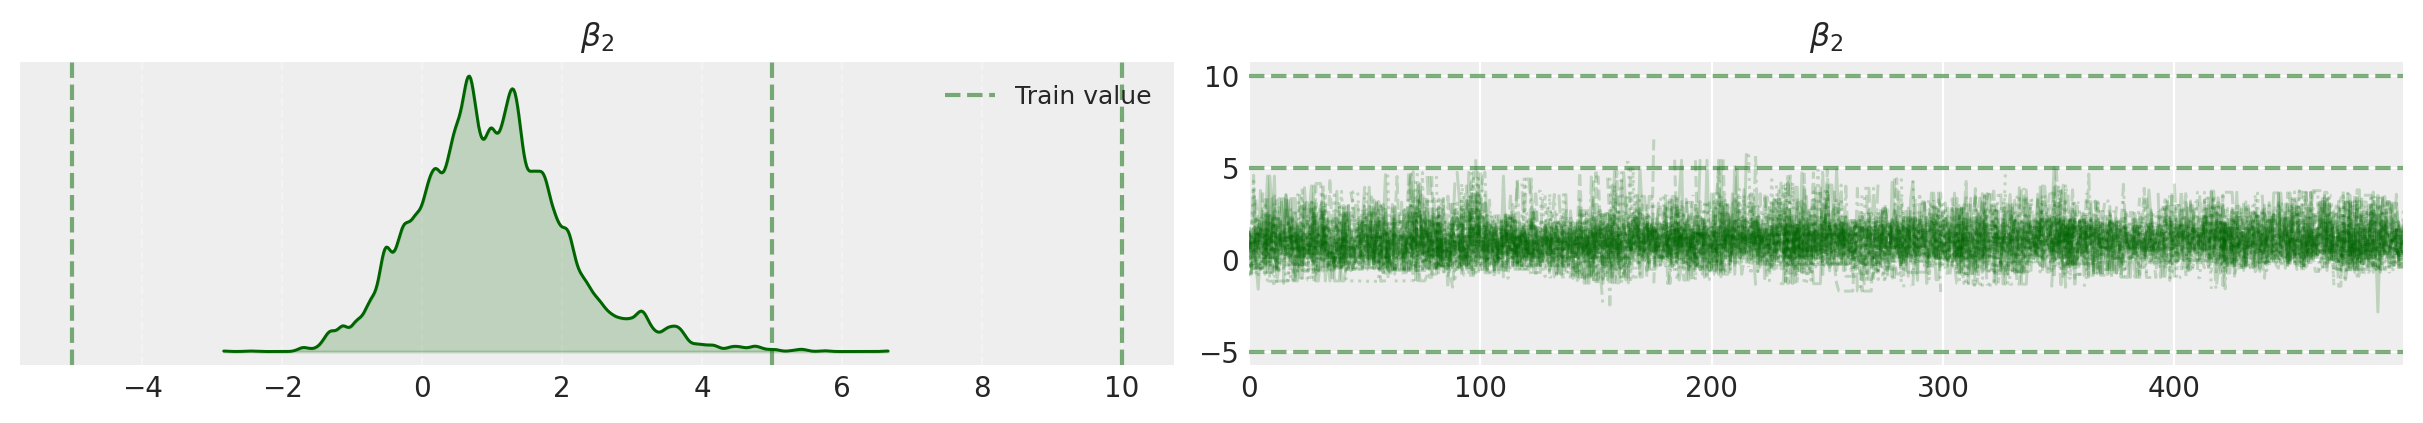

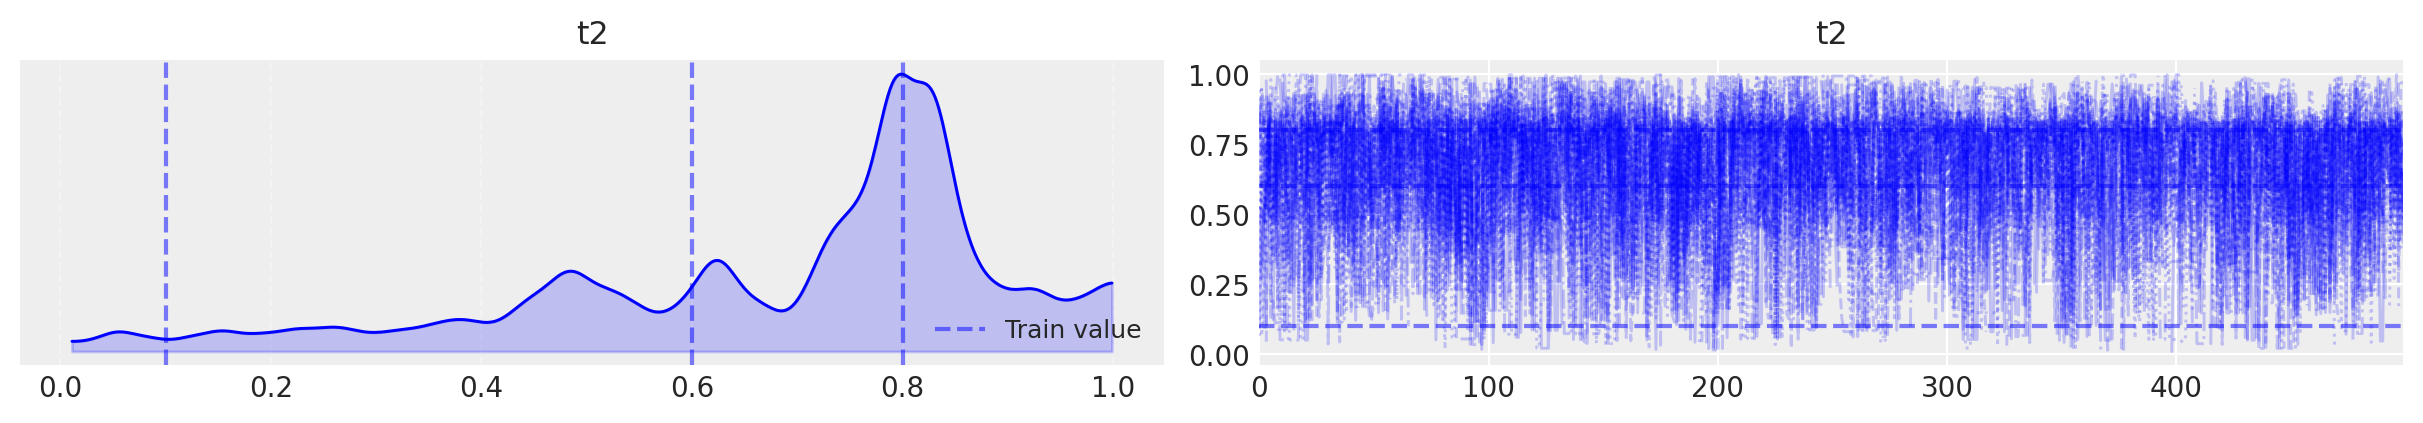

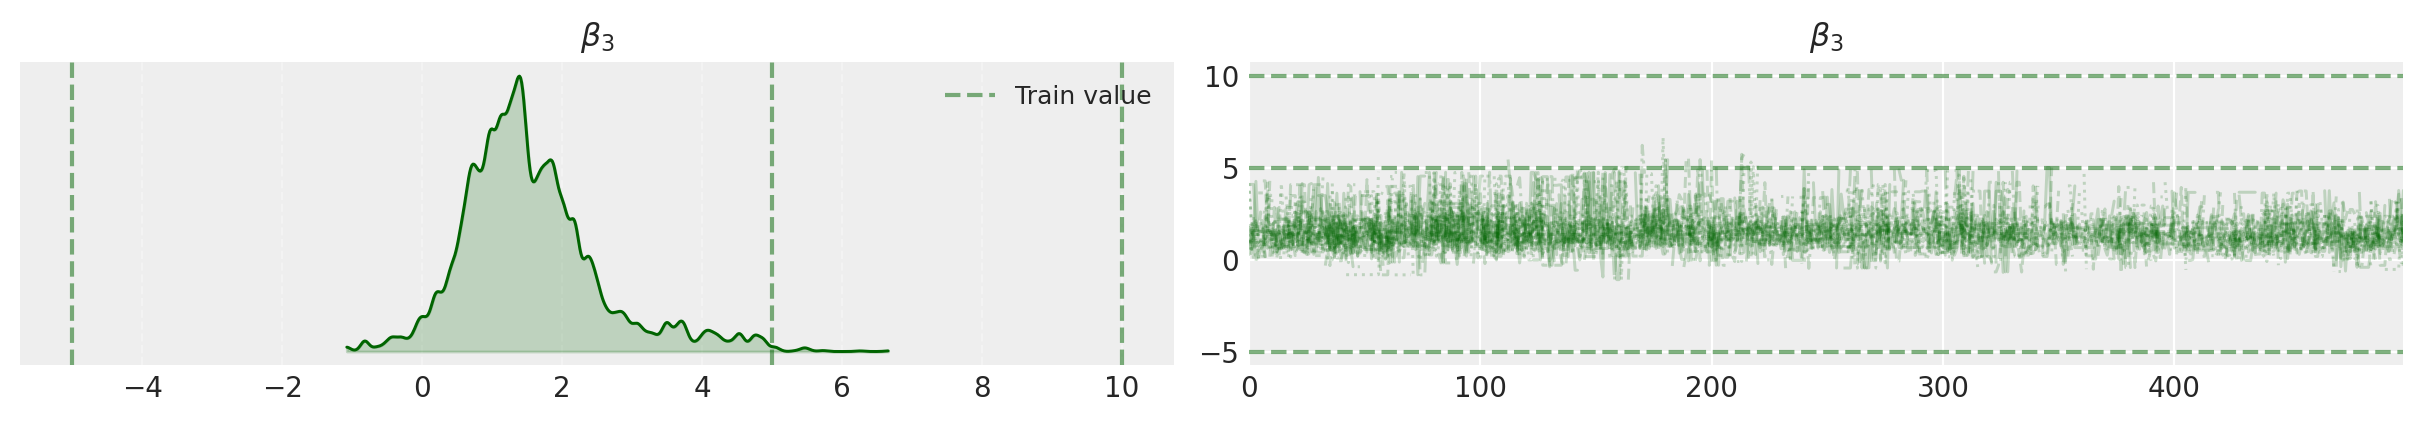

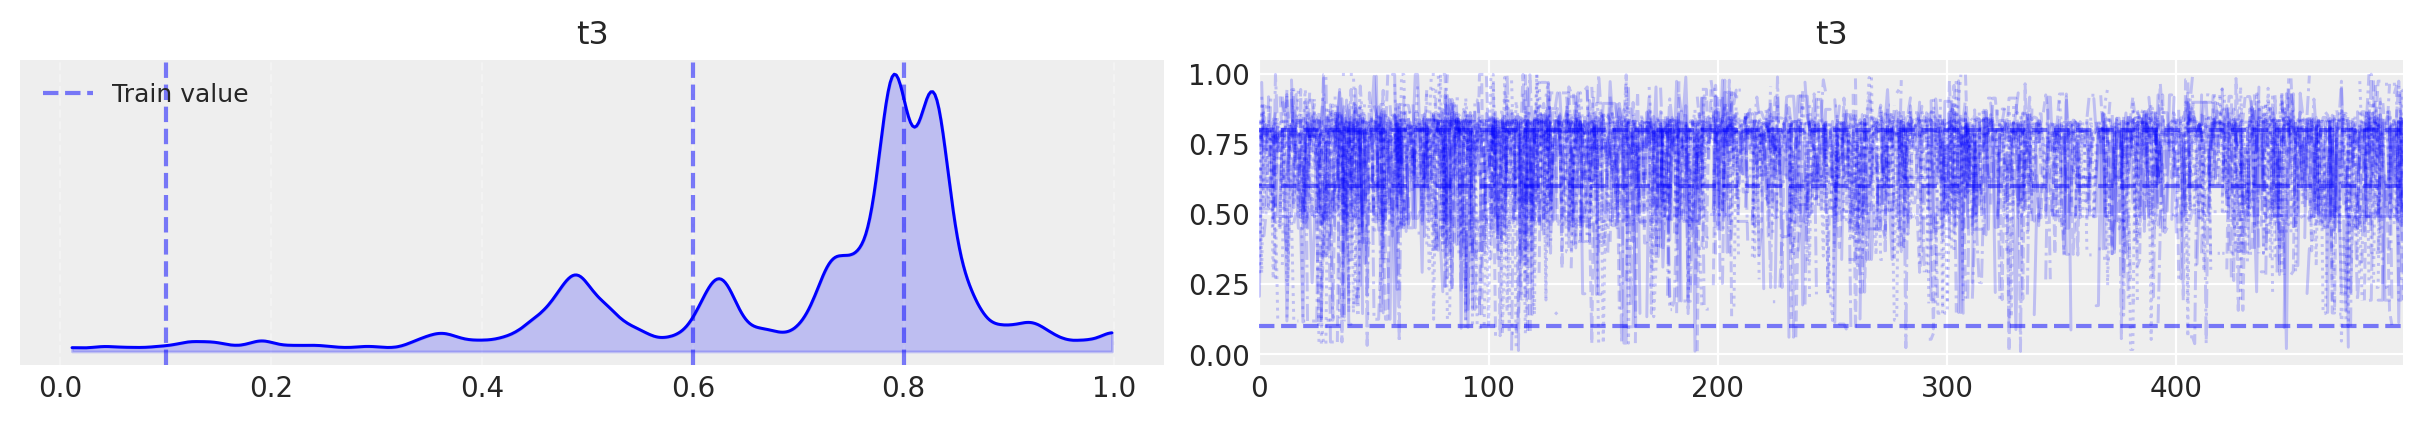

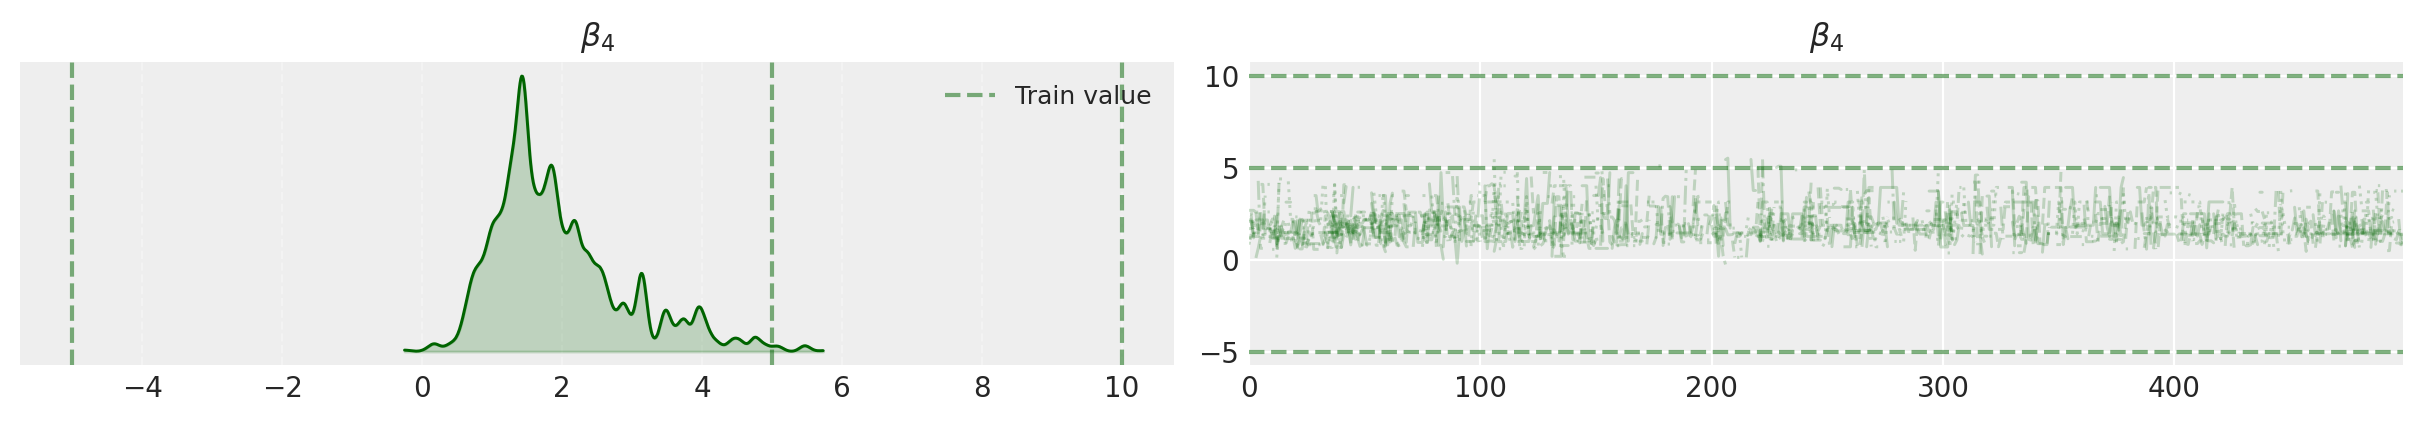

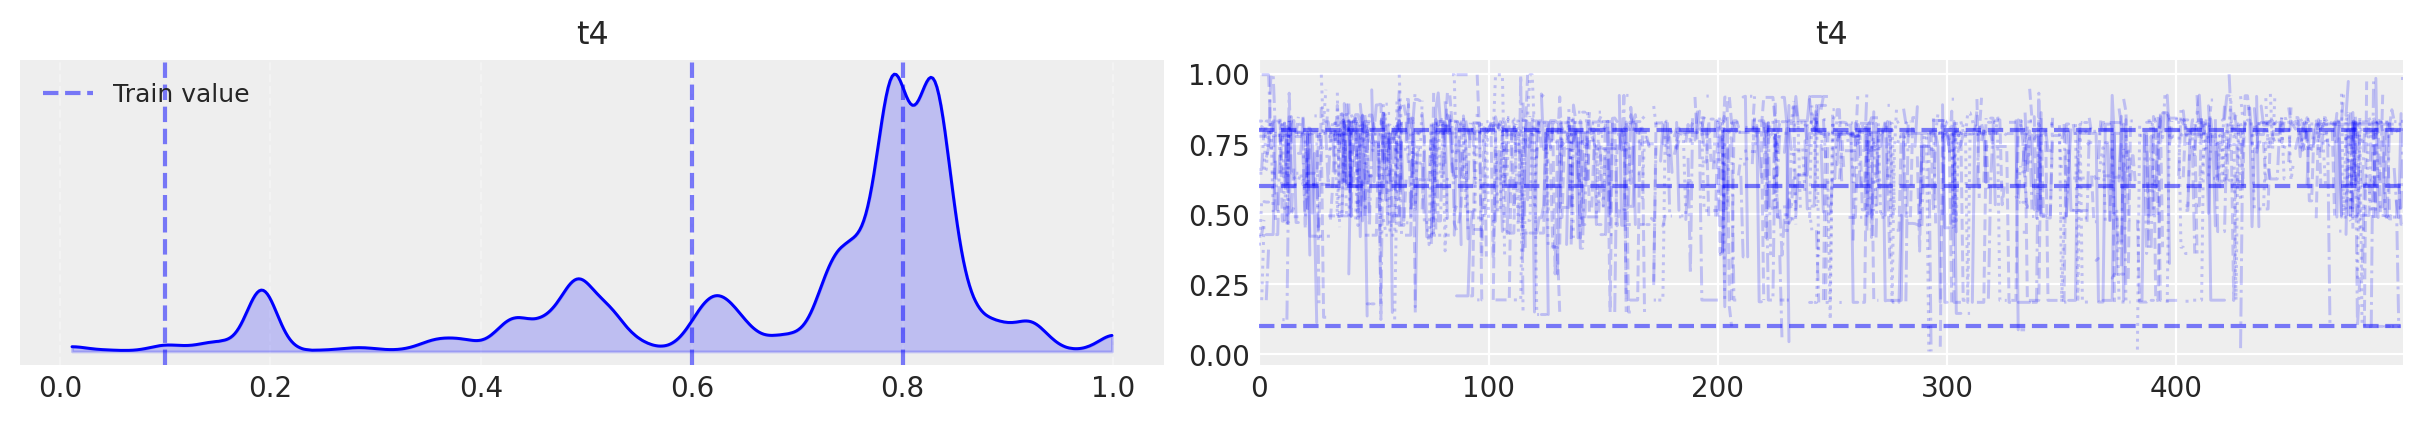

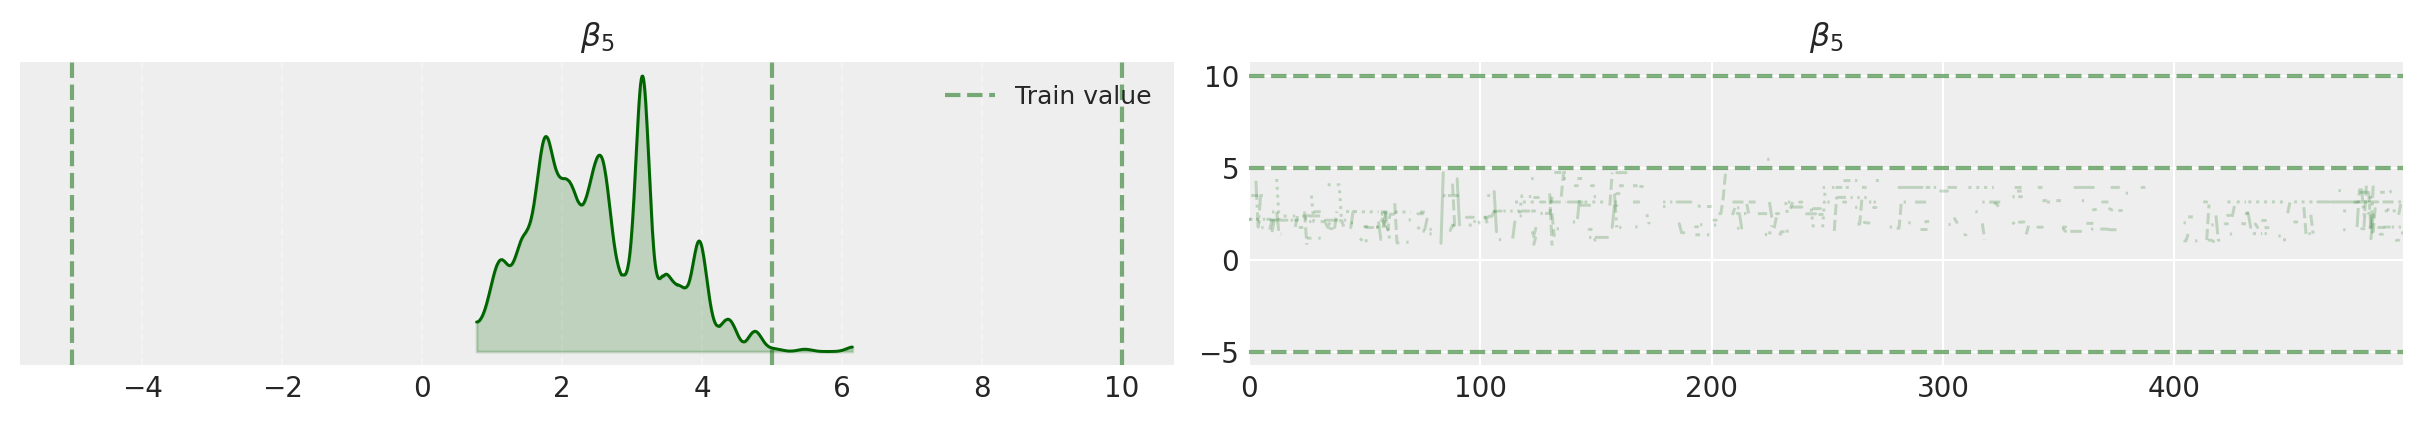

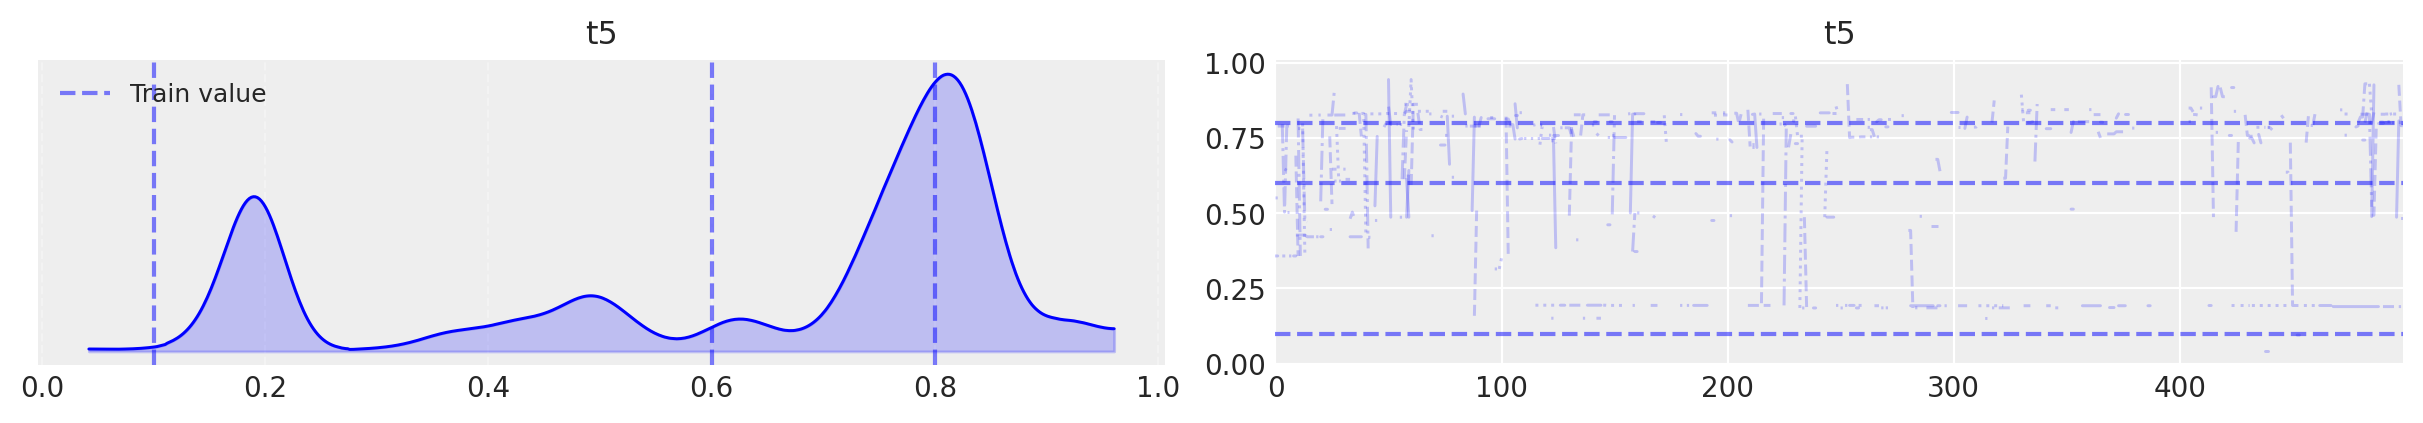

In [13]:
for component_id in range(nleaves_max["components"]):
    plot_utils.plot_trace(
        full_chain_components[..., component_id, THETA_SPACE.idx_beta],
        rf"$\beta_{component_id + 1}$",
        None,
        beta_true if SYNTHETIC_DATA and MODEL_GEN == "RKHS" else None,
        color=COLORS[0],
    )
    plot_utils.plot_trace(
        full_chain_components[..., component_id, THETA_SPACE.idx_tau],
        f"t{component_id + 1}",
        None,
        tau_true if SYNTHETIC_DATA and MODEL_GEN == "RKHS" else None,
        color=COLORS[1],
    )

    if SAVE_FIG:
        plt.savefig(
            DIR_SAVE + f"clf_analysis_trace_{component_id+1}.pdf",
            bbox_inches="tight",
            backend="pgf",
        )

### Trace plot for $\alpha_0$ (for all p)

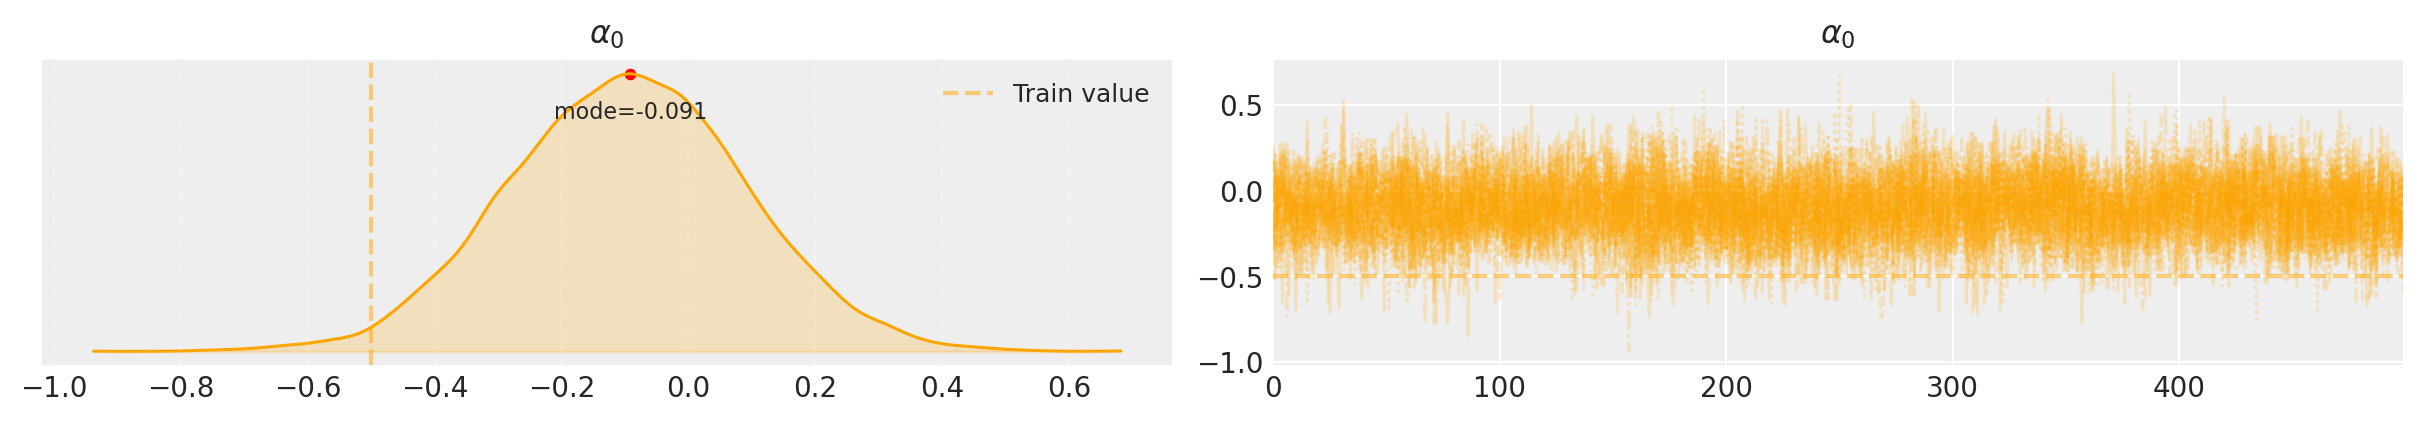

In [21]:
plot_utils.plot_trace(
    full_chain_common[..., THETA_SPACE.idx_alpha0],
    r"$\alpha_0$",
    None,
    alpha0_true if SYNTHETIC_DATA and MODEL_GEN == "RKHS" else None,
    mode=True,
    color=COLORS[2],
)

### Triangular posterior distribution of individual components (for each p)

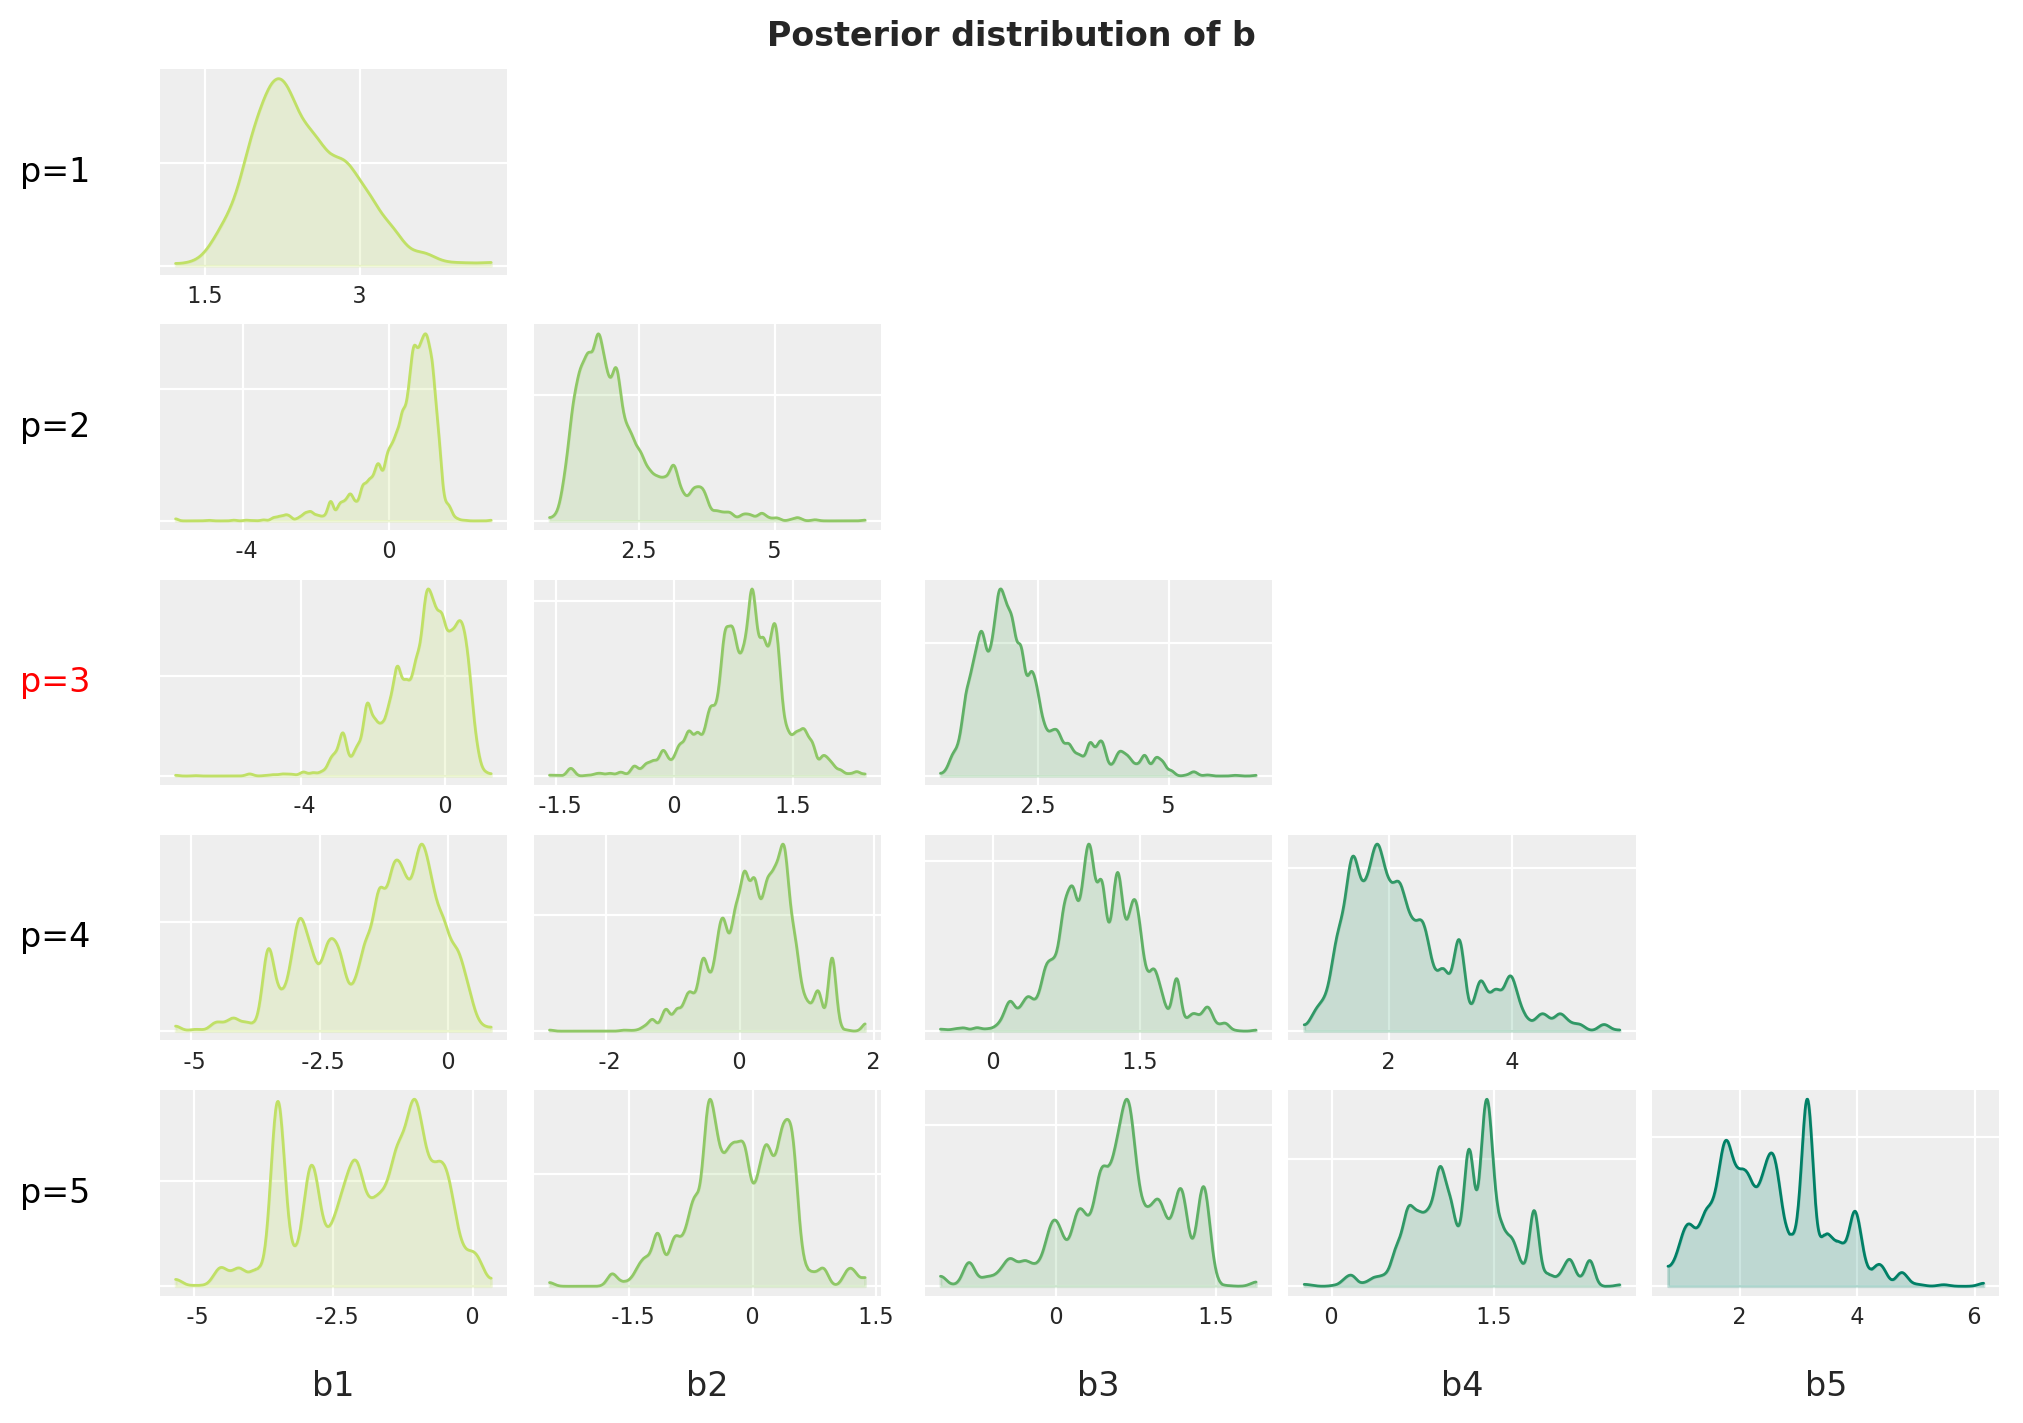

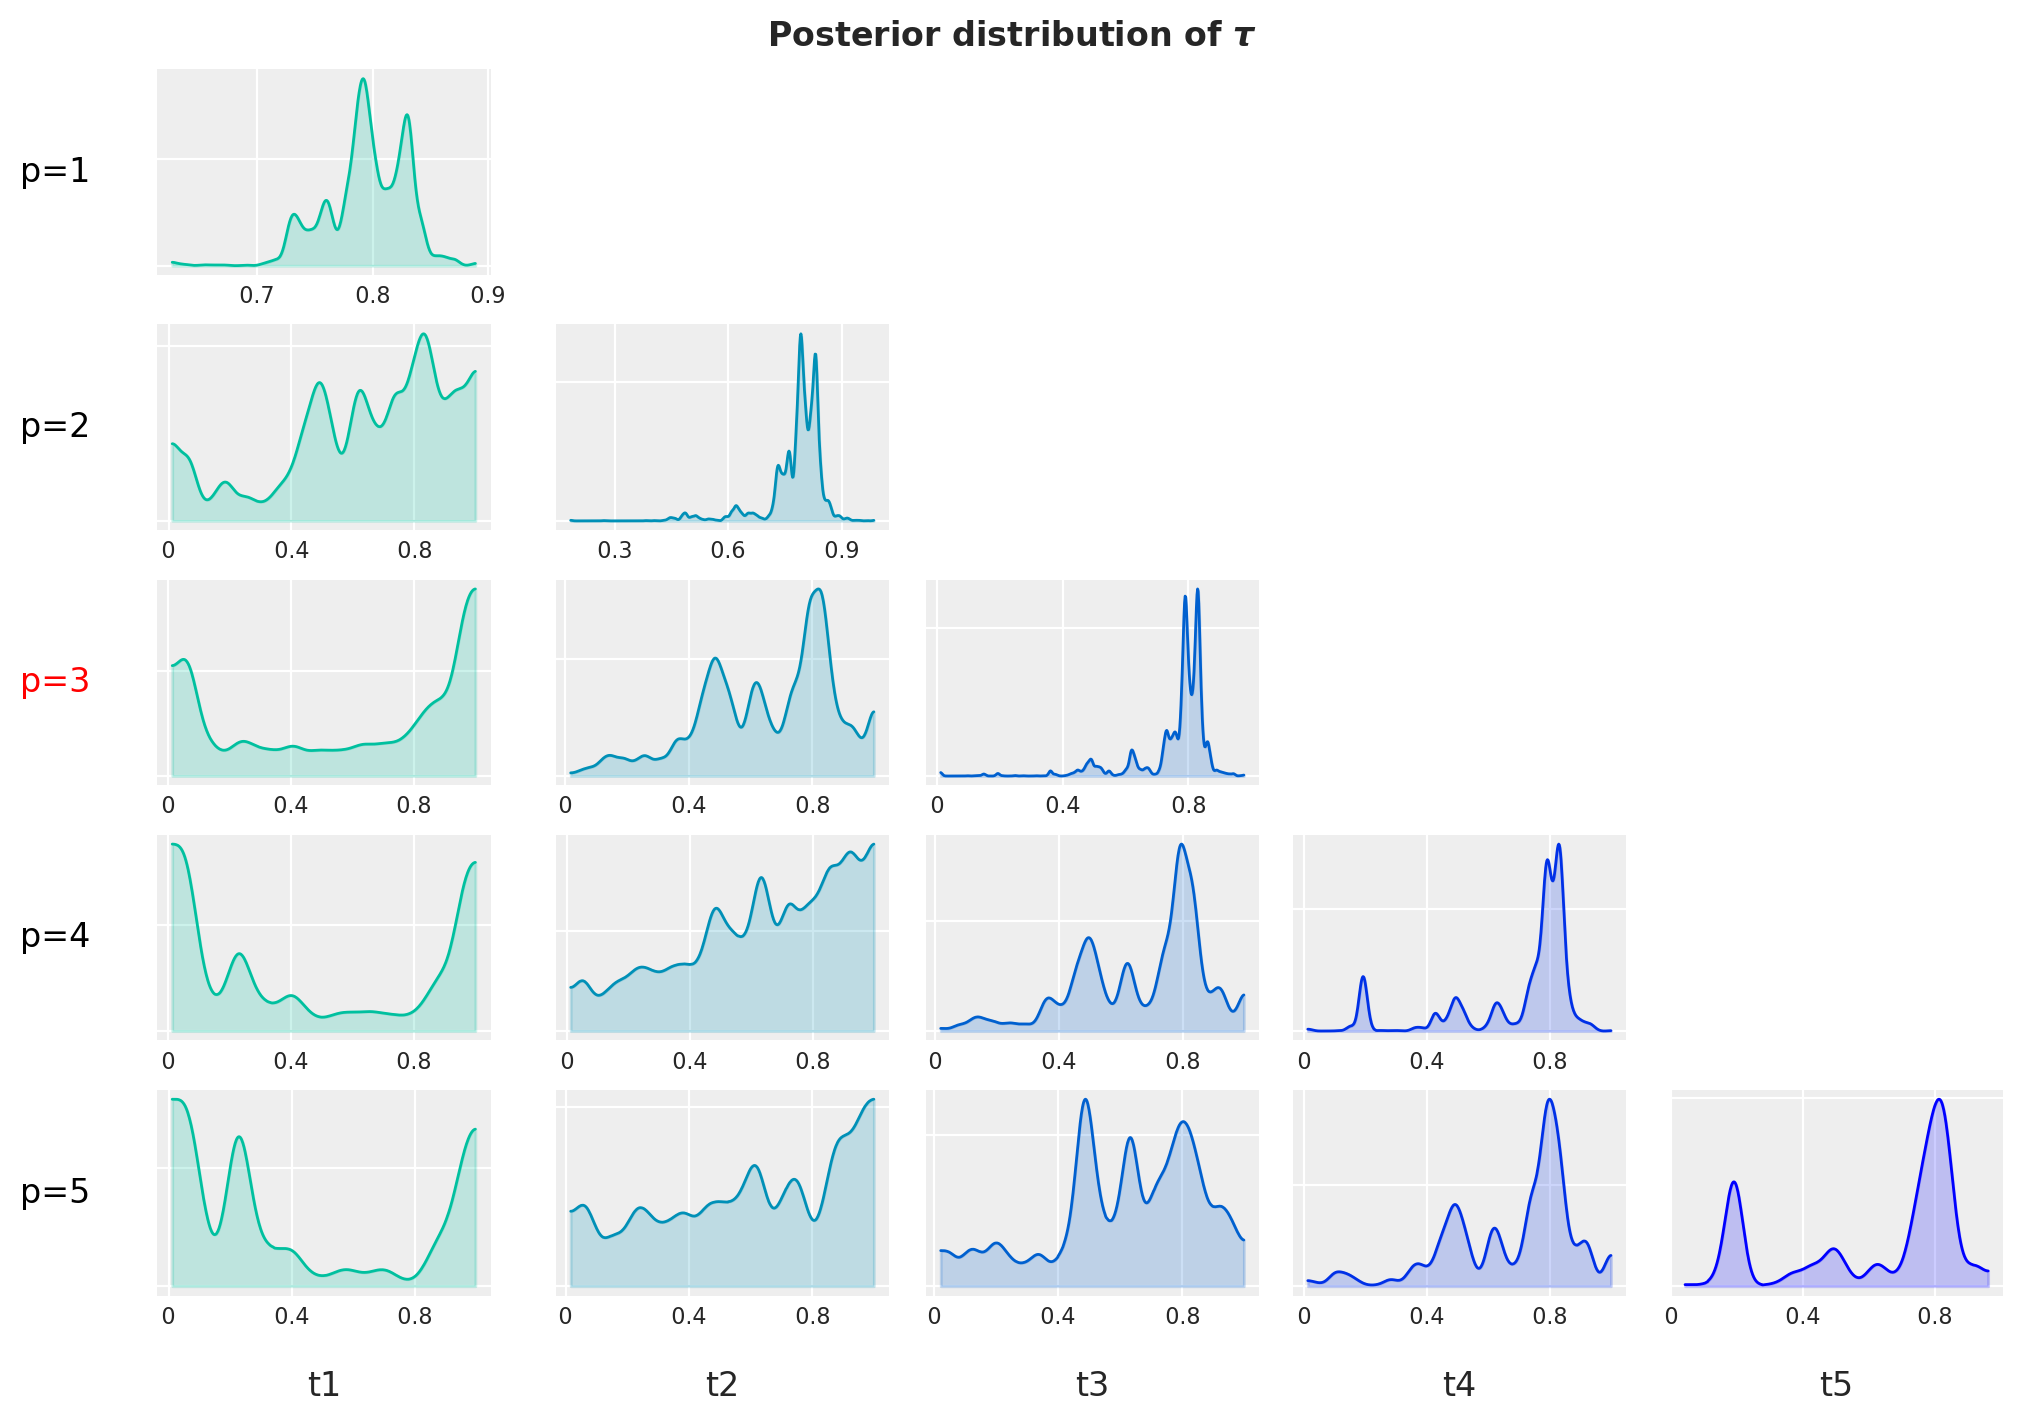

In [17]:
plot_utils.triangular_plot_components(
    full_chain_components,
    nleaves,
    THETA_SPACE.idx_beta,
    "b",
    plt.get_cmap("summer"),
    COLORS[4],
)
plot_utils.triangular_plot_components(
    full_chain_components,
    nleaves,
    THETA_SPACE.idx_tau,
    "t",
    plt.get_cmap("winter"),
    COLORS[4],
)

if SAVE_FIG:
    plt.savefig(
        DIR_SAVE + "clf_analysis_triangular_posterior.pdf",
        bbox_inches="tight",
        backend="pgf",
    )

### Posterior distribution of $\alpha_0$ (for each p)

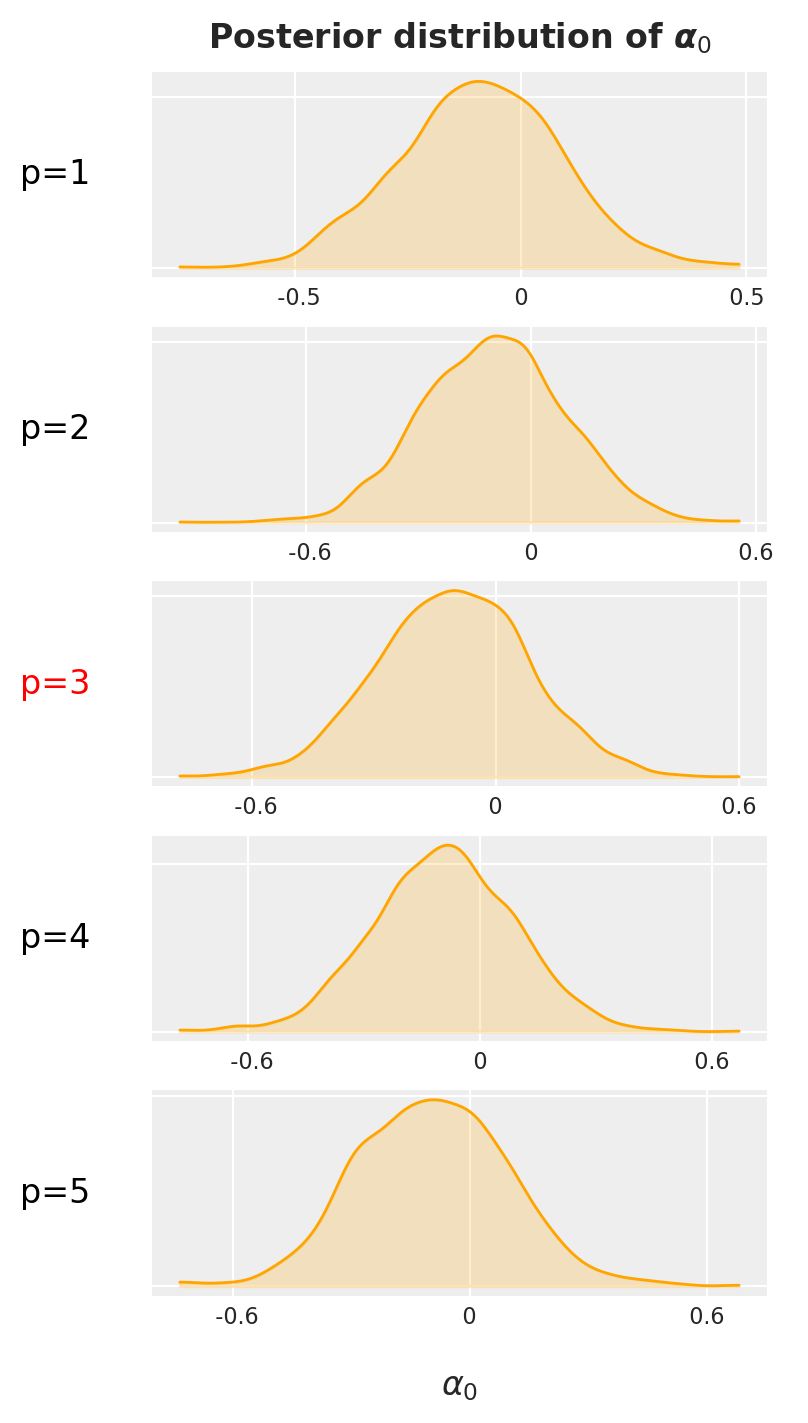

In [22]:
plot_utils.posterior_plot_common(
    full_chain_common,
    nleaves,
    THETA_SPACE.idx_alpha0,
    COLORS[2:4],
    COLORS[4],
    plot_sigma2=False,
)

### Trace plot for p

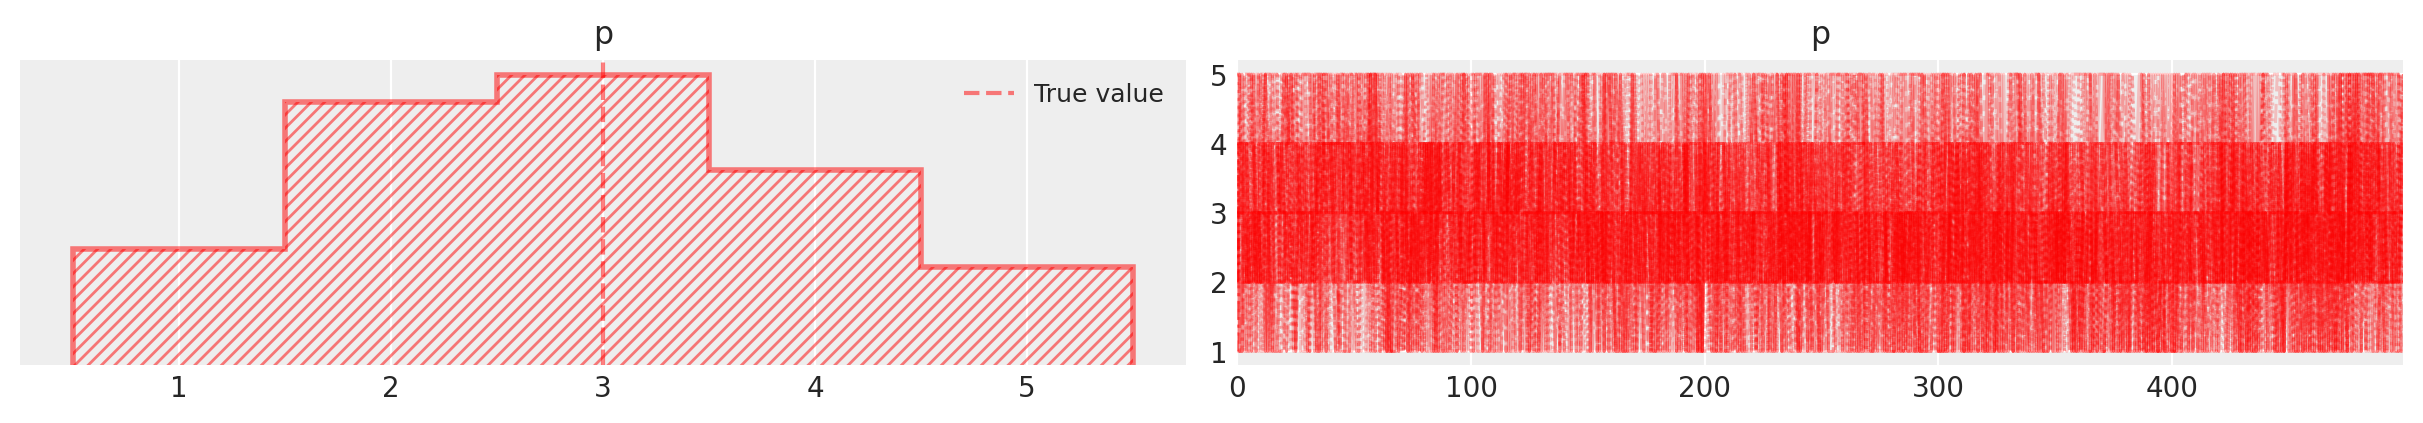

In [23]:
plot_utils.plot_trace_p(
    nleaves,
    nleaves_max["components"],
    COLORS[4],
    p_true=len(beta_true) if SYNTHETIC_DATA and MODEL_GEN == "RKHS" else None,
)

if SAVE_FIG:
    plt.savefig(
        DIR_SAVE + f"clf_analysis_trace_p.pdf", bbox_inches="tight", backend="pgf"
    )

### Tempered posterior distribution of p

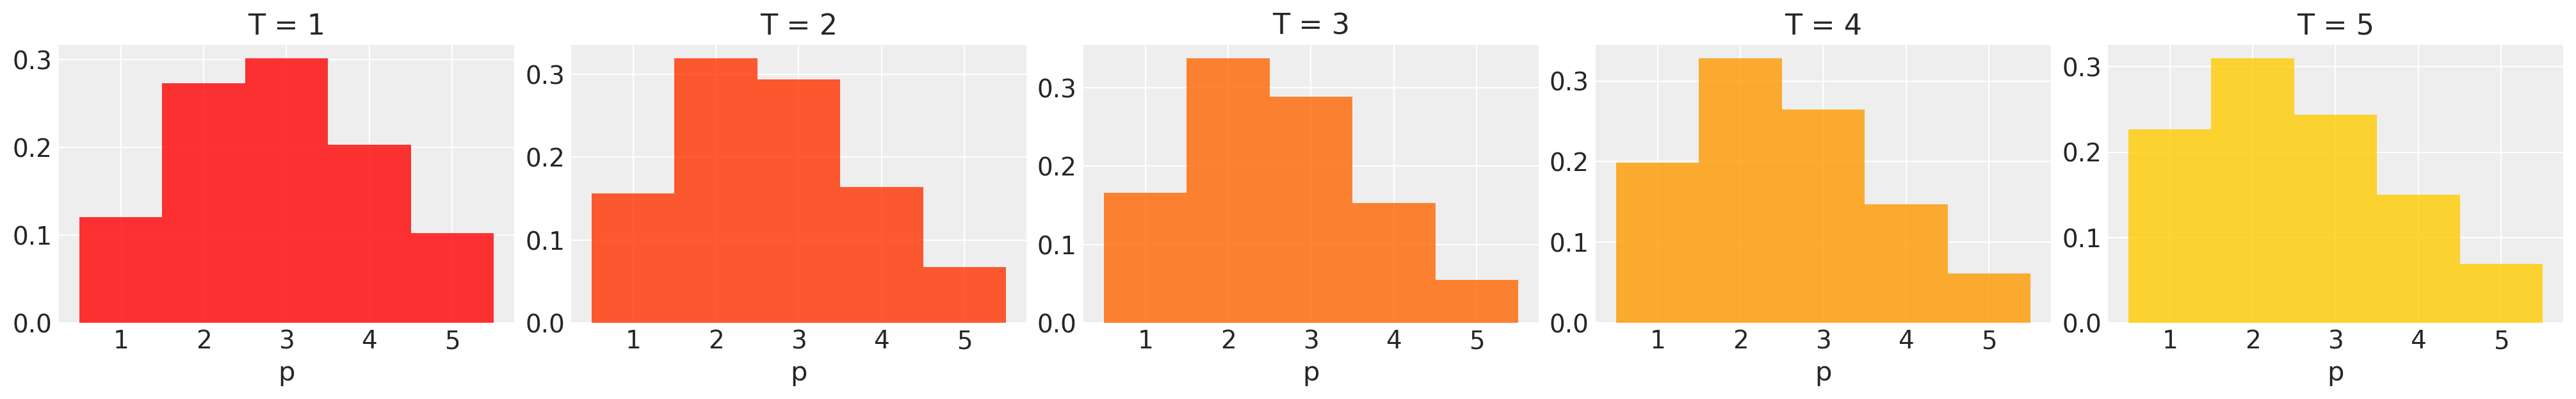

In [24]:
plot_utils.plot_tempered_posterior_p(
    ntemps, nleaves_all_T, nleaves_max["components"], plt.get_cmap("autumn")
)

if SAVE_FIG:
    plt.savefig(
        DIR_SAVE + f"clf_analysis_tempered_posterior_p.pdf",
        bbox_inches="tight",
        backend="pgf",
    )

### Posterior predictive plot for training data

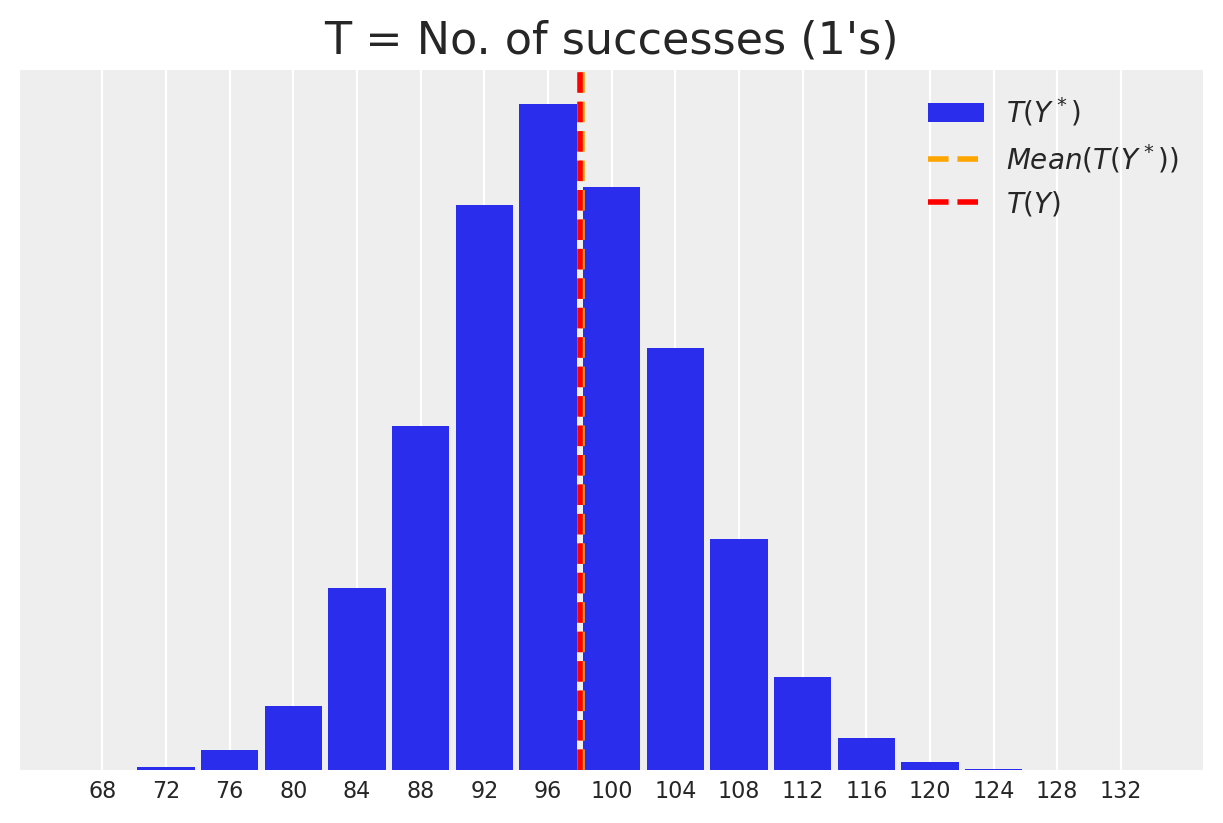

In [25]:
plot_utils.plot_ppc(
    full_chain_components,
    full_chain_common,
    THETA_SPACE,
    X,
    Y,
    is_test_data=False,
    kind="logistic",
)

## Prediction

In this case the prediction scheme is similar to the functional linear regression case. The possible noise in the methods comes from considering Bernoulli distributions or directly using a threshold so that $Y_i=1 \iff p_i \geq 0.5$.

*See [the analogous notebook for linear regression](https://github.com/antcc/rk-bfr-jump/blob/main/demo_linear_regression.ipynb) or Section 2.3 in the [the accompanying paper](https://arxiv.org/abs/2312.14086) for more details.*

In [26]:
FIT_SK = True
RUN_SUMMARY_METHODS = False

SUMMARY_STATISTICS = [
    np.mean,
    lambda x, axis: trim_mean(x, 0.1),
    np.median,
    lambda x, axis: np.apply_along_axis(utility.mode_kde, axis=axis, arr=x),
]

DF_COLUMNS = ["Estimator", "Features", "Noise", "Acc"]
SORT_BY = -1
FOLDS = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

max_used_p = np.max(np.unique(nleaves))

### Reference methods

In [27]:
# -- Fit reference models and show metrics

if FIT_SK:
    classifiers = run_utils.get_reference_models_logistic(
        nleaves_max["components"], SEED
    )

    df_reference, clf_cv = run_utils.cv_sk(
        classifiers,
        X_fd,
        Y,
        X_test_fd,
        Y_test,
        FOLDS,
        kind="logistic",
        n_jobs=-1,
        column_names=[col for col in DF_COLUMNS if col != "Noise"],
        sort_by=SORT_BY,
        verbose=False,
    )
    print("-- All methods --")
    display(
        df_reference.style.apply(
            lambda x: utility.color_reference_methods(x, df_reference)
        ).hide(axis="index")
    )
else:
    print("No reference methods have been fitted.")

-- All methods --


In [28]:
if FIT_SK:
    df_reference_one = df_reference[~df_reference["Estimator"].str.contains("\\+")]
    print("-- One-stage methods --")
    display(
        df_reference_one.style.apply(
            lambda x: utility.color_reference_methods(x, df_reference_one)
        ).hide(axis="index")
    )
else:
    print("No reference methods have been fitted.")

-- One-stage methods --


In [29]:
if FIT_SK:
    df_reference_two = df_reference[df_reference["Estimator"].str.contains("\\+")]
    print("-- Two-stage methods --")
    display(
        df_reference_two.style.apply(
            lambda x: utility.color_reference_methods(x, df_reference_two)
        ).hide(axis="index")
    )
else:
    print("No reference methods have been fitted.")

-- Two-stage methods --


### Method 1 (PP)

In [30]:
np.random.seed(SEED)

noises = [True, False]
names = ["pp_mean", "pp_tmean", "pp_median", "pp_mode"]
df = pd.DataFrame(columns=DF_COLUMNS)

for noise, (name, aggregate_pp) in product(noises, zip(names, SUMMARY_STATISTICS)):
    Y_pred = prediction.predict_pp(
        full_chain_components,
        full_chain_common,
        THETA_SPACE,
        X_test,
        aggregate_pp,
        noise=noise,
        kind="logistic",
    )

    run_utils.fill_df_scores(
        df, Y_test, Y_pred, name, max_used_p, noise, kind="logistic"
    )

df.sort_values(df.columns[SORT_BY], inplace=True, ascending=False)
df_all_methods = df.copy()
df.style.hide(axis="index")

### Method 2 (Weighted PP)

In [31]:
np.random.seed(SEED)

noises = [True, False]
names = ["w_pp_mean", "w_pp_tmean", "w_pp_median", "w_pp_mode"]
df = pd.DataFrame(columns=DF_COLUMNS)

for noise, (name, aggregate_pp) in product(noises, zip(names, SUMMARY_STATISTICS)):
    Y_pred = prediction.predict_weighted_pp(
        full_chain_components,
        full_chain_common,
        nleaves,
        THETA_SPACE,
        X_test,
        aggregate_pp,
        noise=noise,
        kind="logistic",
    )

    run_utils.fill_df_scores(
        df, Y_test, Y_pred, name, max_used_p, noise, kind="logistic"
    )

df.sort_values(df.columns[SORT_BY], inplace=True, ascending=False)
df_all_methods = pd.concat([df_all_methods, df], ignore_index=True)
df.style.hide(axis="index")

### Method 3 (MAP PP)

In [32]:
np.random.seed(SEED)

noises = [True, False]
names = ["map_pp_mean", "map_pp_tmean", "map_pp_median", "map_pp_mode"]
map_p = mode_discrete(nleaves, axis=None).mode
df = pd.DataFrame(columns=DF_COLUMNS)

for noise, (name, aggregate_pp) in product(noises, zip(names, SUMMARY_STATISTICS)):
    Y_pred = prediction.predict_map_pp(
        full_chain_components,
        full_chain_common,
        nleaves,
        map_p,
        THETA_SPACE,
        X_test,
        aggregate_pp,
        noise=noise,
        kind="logistic",
    )

    run_utils.fill_df_scores(df, Y_test, Y_pred, name, map_p, noise, kind="logistic")

df.sort_values(df.columns[SORT_BY], inplace=True, ascending=False)
df_all_methods = pd.concat([df_all_methods, df], ignore_index=True)
df.style.hide(axis="index")

### Method 4 (Weighted summary)

In [33]:
if RUN_SUMMARY_METHODS:
    np.random.seed(SEED)

    names = ["mean", "tmean", "median", "mode"]
    df = pd.DataFrame(columns=DF_COLUMNS)

    for name, summary_statistic in zip(names, SUMMARY_STATISTICS):
        Y_pred = prediction.predict_weighted_summary(
            full_chain_components,
            full_chain_common,
            nleaves,
            THETA_SPACE,
            X_test,
            summary_statistic,
            kind="logistic",
        )

        run_utils.fill_df_scores(
            df, Y_test, Y_pred, "w_summary_" + name, max_used_p, "N/A", kind="logistic"
        )

    df.sort_values(df.columns[SORT_BY], inplace=True, ascending=False)
    df_all_methods = pd.concat([df_all_methods, df], ignore_index=True)
    display(df.style.hide(axis="index"))

### Method 5 (MAP summary)

In [34]:
if RUN_SUMMARY_METHODS:
    np.random.seed(SEED)

    names = ["mean", "tmean", "median", "mode"]
    map_p = mode_discrete(nleaves, axis=None).mode
    df = pd.DataFrame(columns=DF_COLUMNS)

    for name, summary_statistic in zip(names, SUMMARY_STATISTICS):
        Y_pred = prediction.predict_map_summary(
            full_chain_components,
            full_chain_common,
            nleaves,
            map_p,
            THETA_SPACE,
            X_test,
            summary_statistic,
            kind="logistic",
        )

        run_utils.fill_df_scores(
            df, Y_test, Y_pred, "map_summary_" + name, map_p, "N/A", kind="logistic"
        )

    df.sort_values(df.columns[SORT_BY], inplace=True, ascending=False)
    df_all_methods = pd.concat([df_all_methods, df], ignore_index=True)
    display(df.style.hide(axis="index"))

### Method 6 (Weighted variable selection)

In [35]:
np.random.seed(SEED)

names = ["mean", "tmean", "median", "mode"]
params_regularizer = {"clf__C": np.logspace(-4, 4, 20)}
clfs = [
    (
        "log",
        GridSearchCV(
            Pipeline([("clf", LogisticRegression(random_state=SEED))]),
            params_regularizer,
            scoring="accuracy",
            n_jobs=-1,
            cv=FOLDS,
        ),
    )
]
df = pd.DataFrame(columns=DF_COLUMNS)

for (summary_name, summary_statistic), (clf_name, clf) in product(
    zip(names, SUMMARY_STATISTICS), clfs
):
    Y_pred = prediction.predict_weighted_variable_selection(
        full_chain_components,
        full_chain_common,
        nleaves,
        THETA_SPACE,
        X,
        Y,
        X_test,
        summary_statistic,
        clf,
        kind="logistic",
    )

    run_utils.fill_df_scores(
        df,
        Y_test,
        Y_pred,
        "w_vs_" + summary_name + "+" + clf_name,
        max_used_p,
        "N/A",
        kind="logistic",
    )

df.sort_values(df.columns[SORT_BY], inplace=True, ascending=False)
df_all_methods = pd.concat([df_all_methods, df], ignore_index=True)
df.style.hide(axis="index")

### Method 7 (MAP variable selection)

In [36]:
np.random.seed(SEED)

names = ["mean", "tmean", "median", "mode"]
params_regularizer = {"clf__C": np.logspace(-4, 4, 20)}
clfs = [
    (
        "log",
        GridSearchCV(
            Pipeline([("clf", LogisticRegression(random_state=SEED))]),
            params_regularizer,
            scoring="accuracy",
            n_jobs=-1,
            cv=FOLDS,
        ),
    )
]
map_p = mode_discrete(nleaves, axis=None).mode
df = pd.DataFrame(columns=DF_COLUMNS)

for (summary_name, summary_statistic), (clf_name, clf) in product(
    zip(names, SUMMARY_STATISTICS), clfs
):
    Y_pred = prediction.predict_map_variable_selection(
        full_chain_components,
        full_chain_common,
        nleaves,
        map_p,
        THETA_SPACE,
        X,
        Y,
        X_test,
        summary_statistic,
        clf,
        kind="logistic",
    )

    run_utils.fill_df_scores(
        df,
        Y_test,
        Y_pred,
        "map_vs_" + summary_name + "+" + clf_name,
        map_p,
        "N/A",
        kind="logistic",
    )

df.sort_values(df.columns[SORT_BY], inplace=True, ascending=False)
df_all_methods = pd.concat([df_all_methods, df], ignore_index=True)
df.style.hide(axis="index")

## Prediction results analysis

### Posterior predictive plot for test data

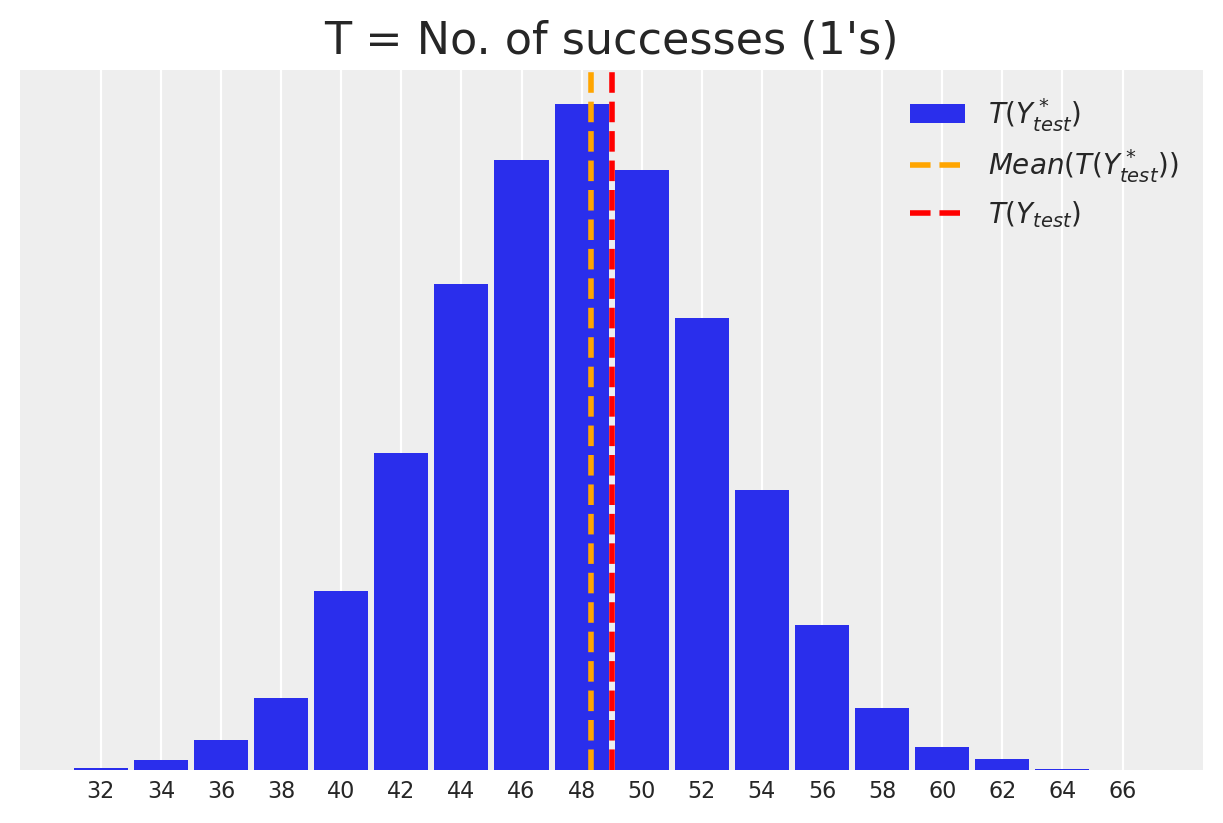

In [37]:
plot_utils.plot_ppc(
    full_chain_components,
    full_chain_common,
    THETA_SPACE,
    X_test,
    Y_test,
    is_test_data=True,
    kind="logistic",
)

### Comparison of all RKHS methods

In [38]:
df_all_methods.sort_values(
    df_all_methods.columns[SORT_BY], inplace=True, ascending=False
)
df_all_methods.drop_duplicates(inplace=True)
df_all_methods.style.hide(axis="index")

In [39]:
print("-- One-stage methods --")
df_all_methods_one = df_all_methods[~df_all_methods["Estimator"].str.contains("\\+")]
df_all_methods_one.style.hide(axis="index")

-- One-stage methods --


In [40]:
print("-- Two-stage methods --")
df_all_methods_two = df_all_methods[df_all_methods["Estimator"].str.contains("\\+")]
df_all_methods_two.style.hide(axis="index")

-- Two-stage methods --


### Comparison with reference methods

In [41]:
if FIT_SK:
    df_comparison_all = pd.concat([df_all_methods, df_reference], ignore_index=True)
    df_comparison_all.sort_values(
        df_comparison_all.columns[SORT_BY], inplace=True, ascending=False
    )
    df_comparison_all = df_comparison_all.drop_duplicates().fillna("N/A")
    print("-- All methods --")
    display(
        df_comparison_all.style.apply(
            lambda x: utility.color_reference_methods(x, df_reference)
        ).hide(axis="index")
    )
else:
    print("No reference methods have been fitted.")

-- All methods --


In [42]:
if FIT_SK:
    print("-- One-stage methods --")
    df_comparison_all_one = df_comparison_all[
        ~df_comparison_all["Estimator"].str.contains("\\+")
    ]
    display(
        df_comparison_all_one.style.apply(
            lambda x: utility.color_reference_methods(x, df_reference)
        ).hide(axis="index")
    )
else:
    print("No reference methods have been fitted.")

-- One-stage methods --


In [43]:
if FIT_SK:
    print("-- Two-stage methods --")
    df_comparison_all_two = df_comparison_all[
        df_comparison_all["Estimator"].str.contains("\\+")
    ]
    display(
        df_comparison_all_two.style.apply(
            lambda x: utility.color_reference_methods(x, df_reference)
        ).hide(axis="index")
    )
else:
    print("No reference methods have been fitted.")

-- Two-stage methods --


### Visual comparison with reference methods

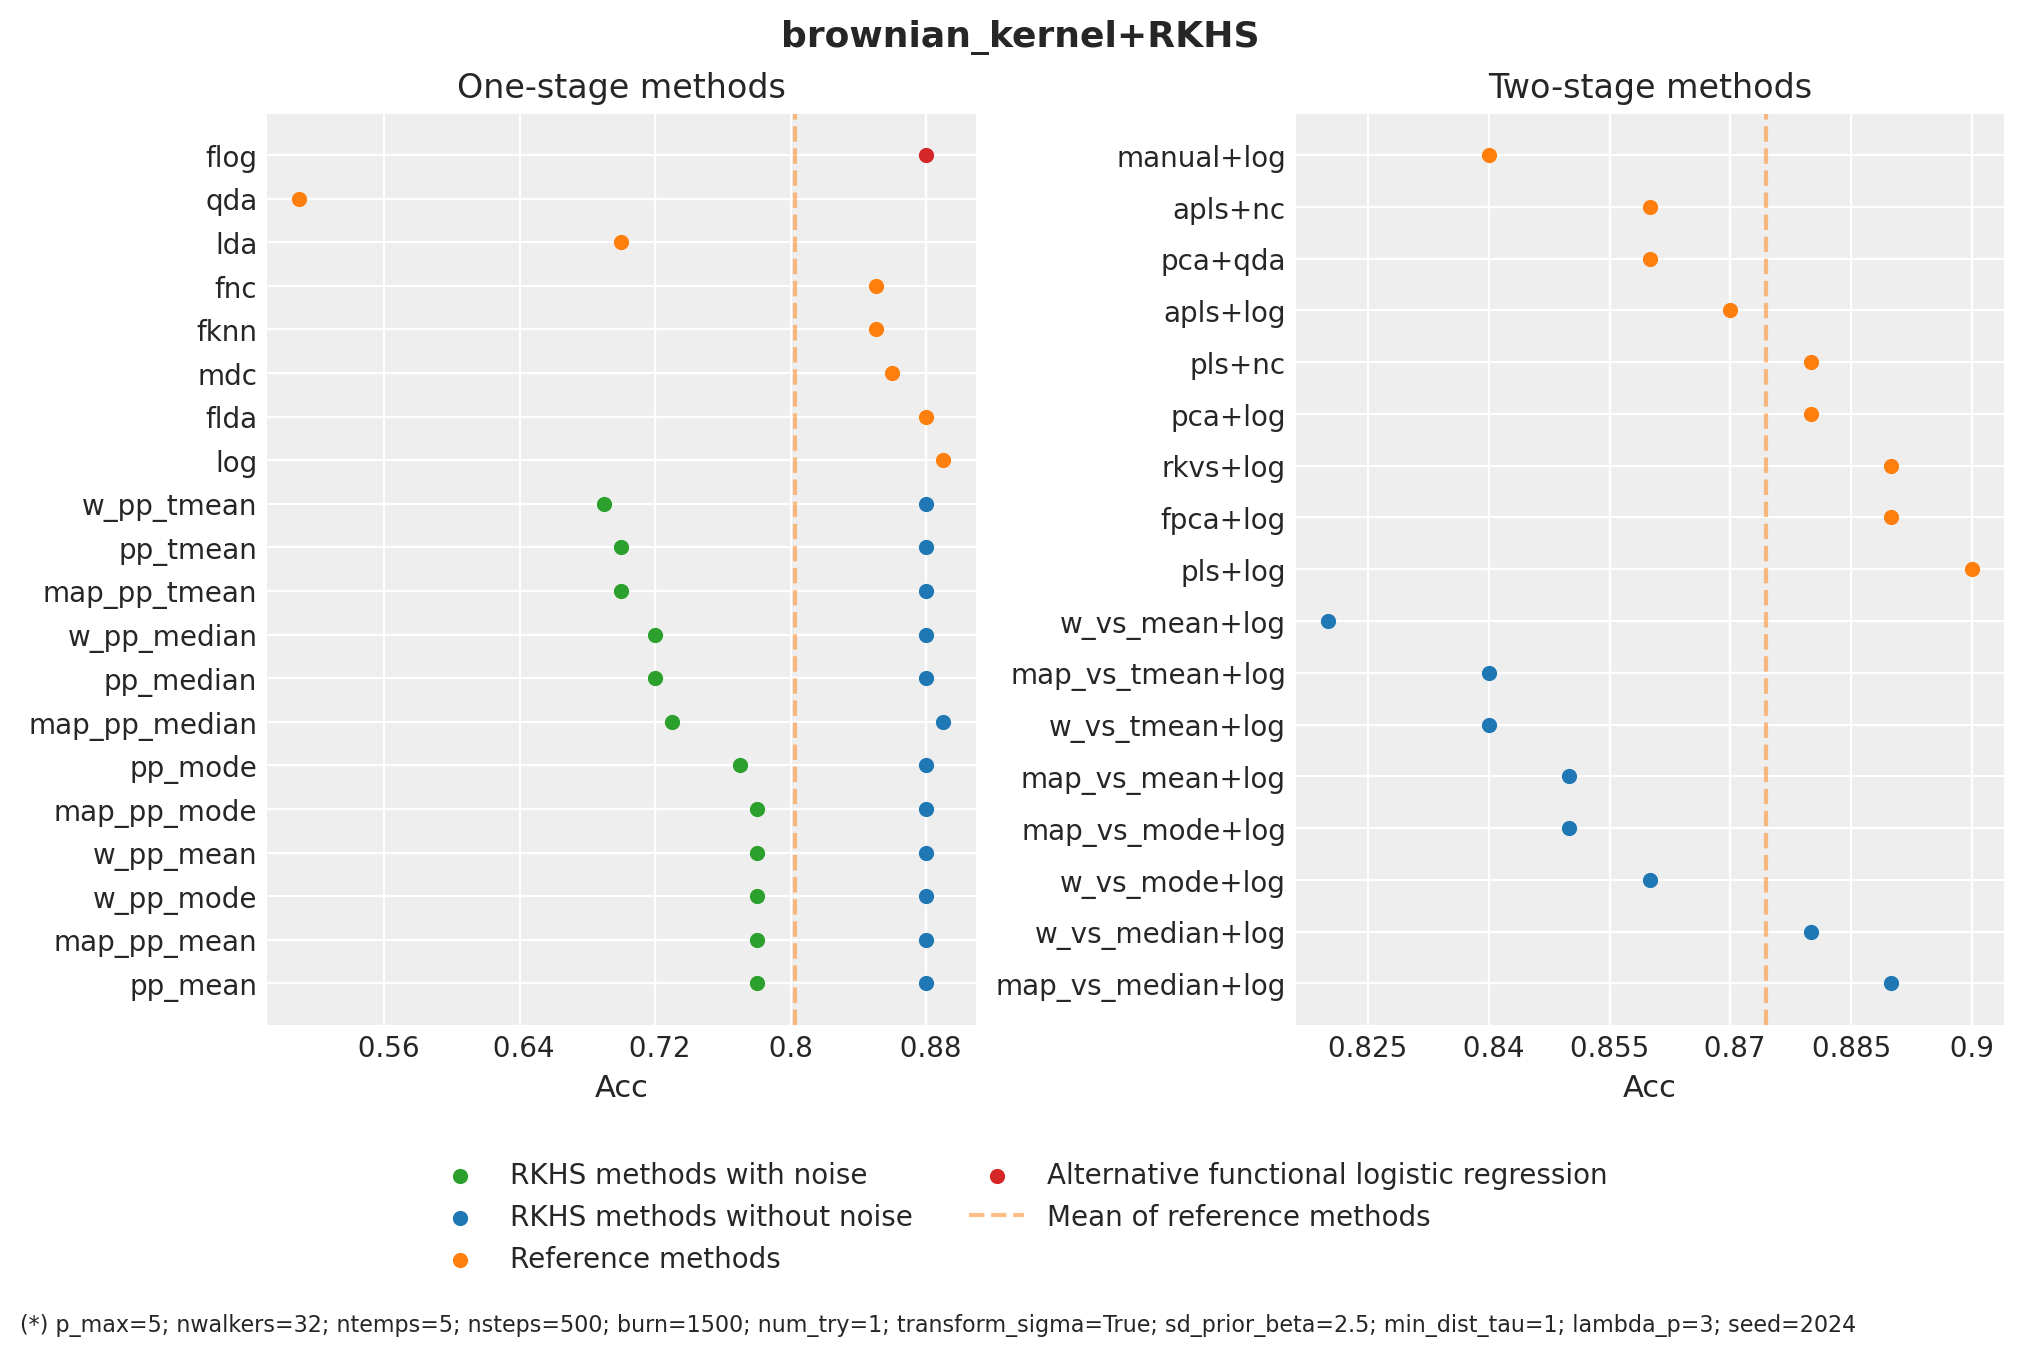

In [46]:
ADD_SAMPLING_INFO = True
SHOW_REFERENCE_METHODS = True
SCORE_NAME = "Acc"

if SYNTHETIC_DATA:
    title = f"{kernel_fn.__name__}+{MODEL_GEN}" if MODEL_GEN != "MIXTURE" else "mixture"
else:
    title = f"{REAL_DATA}"

fig = plot_utils.plot_prediction_results(
    df_all_methods_one,
    df_all_methods_two,
    df_reference_one if FIT_SK and SHOW_REFERENCE_METHODS else None,
    df_reference_two if FIT_SK and SHOW_REFERENCE_METHODS else None,
    title,
    score=SCORE_NAME,
    kind="logistic",
)

if ADD_SAMPLING_INFO:
    _ = fig.text(
        0,
        -0.2,
        f"(*) p_max={nleaves_max['components']}; nwalkers={nwalkers}; ntemps={ntemps}; "
        f"nsteps={nsteps}; burn={burn}; num_try={NUM_TRY if LAMBDA_P is None else 1}; transform_sigma={TRANSFORM_SIGMA}; "
        f"sd_prior_beta={SCALE_PRIOR_BETA}; min_dist_tau={MIN_DIST_TAU}; lambda_p={LAMBDA_P}; seed={SEED}",
        ha="left",
        fontsize=8,
    )

if SAVE_FIG:
    import datetime

    fig.savefig(
        f"results/figures/{datetime.datetime.now().strftime('%Y-%m-%d-%H:%M:%S')}.pdf",
        bbox_inches="tight",
    )

### Save & load prediction scores

In [79]:
SAVE_PREDICTION_RESULTS = False

if SAVE_PREDICTION_RESULTS:
    if SYNTHETIC_DATA:
        filename = (
            f"{kernel_fn.__name__ if REGRESSOR_GEN == 'GP' else 'GBM'}+{MODEL_GEN}"
        )
    else:
        filename = f"{REAL_DATA}"

    if FIT_SK:
        df_comparison_all.to_csv(f"results/scores/{filename}_{SEED}.csv", index=False)
    else:
        df_all_methods.to_csv(f"results/scores/{filename}_{SEED}.csv", index=False)

In [80]:
LOAD_PREDICTION_RESULTS = False
FILENAME_LOAD = "results/scores/brownian_kernel+RKHS_2024.csv"

if LOAD_PREDICTION_RESULTS:
    df_all = pd.read_csv("results/scores/brownian_kernel+RKHS_2024.csv")
    df_all = df_all.drop_duplicates().fillna("N/A")
    display(df_all.style.hide(axis="index"))

## Command line experiments execution

In [81]:
RUN_CMD_EXPERIMENTS = False

if RUN_CMD_EXPERIMENTS:
    !python experiments.py \
        linear l2 --kernel fbm \
        --seed 2024 \
        --nreps 2 \
        --nwalkers 32 --ntemps 5 --nleaves-max 5 \
        --nsteps 500 --nburn 1000 --num-try 2 \
        --sd-prior-beta 5 --lambda-p 3 \
        --verbose 1

## Notebook metadata

In [45]:
%watermark -n -u -v -iv -w

Last updated: Mon Jul 29 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

numpy     : 1.23.5
matplotlib: 3.8.2
pandas    : 2.1.4

Watermark: 2.4.3

